In [1]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
from collections import defaultdict
from datetime import datetime, timedelta
import pickle

from keras.layers import Dense, LSTM, Dropout
from keras.models import Model, Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


In [2]:
## import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

## import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

## import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

## import the IBES analysts estimates data
estimates_df = pd.read_csv(
        '../Data/eikon_ibes_data_1995.csv',
        index_col = 0,
        parse_dates = True, 
)#.fillna(method = 'ffill').dropna(axis = 1, how = 'any')

In [3]:
# create a monthly date range 
dates = pd.date_range('1995-01', '2020-01', freq = 'BM').strftime('%Y-%m')

# # resample price data to weekly intervals starting in 2005
prices_df = prices_df.loc['1995-01-01':, :]
spx_df = spx_df.loc['1995-01-01':, :]

In [4]:
estimates_df.columns = [
    'RIC',
    'Number of Analysts', 
    'Earnings Per Share FY0 - Actual',
    'Earnings Per Share FY0 - Mean', 
    'Earnings Per Share FY1 - Mean',
    'Earnings Per Share FY2 - Mean', 
    'Earnings Per Share FQ0 - Actual',
    'Earnings Per Share FQ0 - Mean', 
    'Earnings Per Share FQ1 - Mean',
    'Earnings Per Share FQ2 - Mean', 
    'Earnings Per Share FQ3 - Mean',
    'Earnings Per Share FQ4 - Mean'
]

estimates_df.head()

,RIC,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean
1990-01-31,SK.N^E98,24.0,0.84667,0.83588,0.92667,1.10083,0.20000,0.23308,0.30143,0.22500,0.23750,0.24333
1990-01-31,CSCO.OQ,0.0,0.00118,NaN,NaN,NaN,0.00069,NaN,NaN,NaN,NaN,NaN
1990-01-31,EXPD.OQ,9.0,0.03906,0.03917,0.04861,0.05893,0.00417,0.00375,0.00531,0.00625,0.00625,0.00563
1990-01-31,CERN.OQ,3.0,0.00781,NaN,0.01667,0.01896,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31,TAPb.N^D04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
## split the data into training and test data
train_start_date = '1995-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2019-12-31'

train_prices_df = prices_df[train_start_date:train_end_date]
test_prices_df = prices_df[test_start_date:test_end_date]

# train_returns_df = returns_df[train_start_date:train_end_date]
# test_returns_df = returns_df[test_start_date:test_end_date]

train_spx_df = spx_df[train_start_date:train_end_date]
test_spx_df = spx_df[test_start_date: test_end_date]

# train_spx_returns_df = spx_returns_df[train_start_date: train_end_date]
# test_spx_returns_df = spx_returns_df[test_start_date: test_end_date]

train_estimates_df = estimates_df[train_start_date:train_end_date]
test_estimates_df = estimates_df[test_start_date:test_end_date]

In [6]:
# quick check for NaN values
n_nan = 0
for df in [
#     train_returns_df, 
#     test_returns_df, 
#     train_spx_returns_df, 
#     test_spx_returns_df
]:
    n_nan += df.isna().sum().values.sum()
    if n_nan > 0: 
        print(n_nan, ' NaN values exist')

In [8]:
map_df.loc[map_df['ISIN'] == 'US98389B1008', :] # Most representative according to AE

,RIC,SEDOL,ISIN,CUSIP,Company Common Name,GICS Sector Name,GICS Industry Name
Instrument,,,,,,,
XEL.OQ,XEL.OQ,2614807,US98389B1008,98389B100,Xcel Energy Inc,Utilities,Electric Utilities


In [9]:
start_date = '2010-01-01'
end_date = '2019-12-31'

In [10]:
price_df = prices_df.loc[start_date:end_date, 'US98389B1008']
price_df = price_df.resample('M').last()
price_df

Code
2010-01-31    20.780001
2010-02-28    20.809999
2010-03-31    21.200001
2010-04-30    21.750000
2010-05-31    20.490000
                ...    
2019-08-31    64.220001
2019-09-30    64.889999
2019-10-31    63.509998
2019-11-30    61.490002
2019-12-31    63.490002
Freq: M, Name: US98389B1008, Length: 120, dtype: float32

In [11]:
top_co_df = copy.deepcopy(estimates_df.loc[estimates_df['RIC'] == 'SO.N', :])
top_co_df.drop('RIC', axis = 1, inplace = True)
top_co_df = top_co_df.loc[start_date:end_date]

In [12]:
price_df.shape, top_co_df.shape

((120,), (120, 11))

In [13]:
top_co_df['price'] = price_df.values
top_co_df['eps_fq0_surprise'] = top_co_df['Earnings Per Share FQ0 - Actual'] - top_co_df['Earnings Per Share FQ0 - Mean']
top_co_df['eps_fy0_surprise'] = top_co_df['Earnings Per Share FY0 - Actual'] - top_co_df['Earnings Per Share FY0 - Mean']

In [14]:
top_co_df

,Number of Analysts,Earnings Per Share FY0 - Actual,Earnings Per Share FY0 - Mean,Earnings Per Share FY1 - Mean,Earnings Per Share FY2 - Mean,Earnings Per Share FQ0 - Actual,Earnings Per Share FQ0 - Mean,Earnings Per Share FQ1 - Mean,Earnings Per Share FQ2 - Mean,Earnings Per Share FQ3 - Mean,Earnings Per Share FQ4 - Mean,price,eps_fq0_surprise,eps_fy0_surprise
2010-01-29,20.0,2.32,2.31075,2.36737,2.53533,0.31,0.29527,0.43800,0.61971,1.03567,0.28880,20.780001,0.01473,0.00925
2010-02-26,20.0,2.32,2.31075,2.35053,2.51375,0.31,0.29527,0.43333,0.61167,0.98400,0.33000,20.809999,0.01473,0.00925
2010-03-31,21.0,2.32,2.31075,2.34950,2.51059,0.31,0.29527,0.43125,0.61000,0.99286,0.32000,21.200001,0.01473,0.00925
2010-04-30,23.0,2.32,2.31075,2.37364,2.52095,0.60,0.43688,0.58455,0.97778,0.28333,0.47250,21.750000,0.16312,0.00925
2010-05-31,23.0,2.32,2.31075,2.38773,2.52238,0.60,0.43688,0.57455,0.98200,0.27667,0.50200,20.490000,0.16312,0.00925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-30,20.0,3.07,3.04460,3.03033,3.15453,0.80,0.72633,1.13893,0.41407,0.71157,0.76629,64.220001,0.07367,0.02540
2019-09-30,20.0,3.07,3.04460,3.03850,3.15453,0.80,0.72633,1.14393,0.40836,0.71729,0.76914,64.889999,0.07367,0.02540
2019-10-31,20.0,3.07,3.04460,3.08985,3.17330,1.34,1.14413,0.32814,0.72771,0.76143,1.18983,63.509998,0.19587,0.02540
2019-11-29,19.0,3.07,3.04460,3.09321,3.17553,1.34,1.14413,0.31939,0.73633,0.76217,1.18667,61.490002,0.19587,0.02540


In [15]:
top_co_df = top_co_df.fillna(method = 'ffill') 
top_co_df.isna().sum()

Number of Analysts                 0
Earnings Per Share FY0 - Actual    0
Earnings Per Share FY0 - Mean      0
Earnings Per Share FY1 - Mean      0
Earnings Per Share FY2 - Mean      0
Earnings Per Share FQ0 - Actual    0
Earnings Per Share FQ0 - Mean      0
Earnings Per Share FQ1 - Mean      0
Earnings Per Share FQ2 - Mean      0
Earnings Per Share FQ3 - Mean      0
Earnings Per Share FQ4 - Mean      0
price                              0
eps_fq0_surprise                   0
eps_fy0_surprise                   0
dtype: int64

___
## Train Test Split

In [16]:
# 5 years of test data
train_len = top_co_df.shape[0] - 60

train = top_co_df.iloc[:train_len]
test = top_co_df.iloc[train_len:]

train.shape, test.shape

((60, 14), (60, 14))

___
## Scale Data

In [17]:
scaler = MinMaxScaler()

scaler.fit(train) # WE ONLY FIT TO TRAINING DATA
scaled_train = scaler.transform(train) # each column ranges from 0 to 1
scaled_test = scaler.transform(test)

scaled_train.max(), scaled_test.max()

(1.0000000000000002, 2.8775116156060445)

___
## Time Series Generator

In [18]:
n_input = 12
n_cols = scaled_train.shape[1]

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

___
## Hyperparameter Search

In [19]:
def hyper_search(
    n_input, 
    n_nodes_list, 
    lr = 0.0001,
    rate_dropout = 0.0, 
    act_funct = 'relu',  
    batch_size = 1,
    epochs = 100,
    patience = 3, 
    early_stop_bool = True
):

    ## Time-Series Generator
    n_cols = scaled_train.shape[1]
    generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)
    val_generator = TimeseriesGenerator(scaled_test, scaled_test, length = n_input, batch_size = 1)


    ## Build LSTM model
    seq_bool = [True] * len(n_nodes_list)
    seq_bool[-1] = False
    
    model = Sequential()
    
    for layer in range(len(n_nodes_list)):
        if layer == 0:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer], 
                input_shape = (n_input, n_cols)
            ))
        else:
            model.add(LSTM(
                n_nodes_list[layer], 
                activation = act_funct, 
                return_sequences = seq_bool[layer]
            ))
        if rate_dropout != 0.0:
            model.add(Dropout(rate = rate_dropout))
    
    model.add(Dense(n_cols))
    opt = Adam(learning_rate = lr)
    model.compile(optimizer = opt, loss = 'mean_squared_error')


    ## Fit LSTM model
    if early_stop_bool:
        early_stopping = EarlyStopping(monitor = 'loss', patience = patience)
        model.fit_generator(
            generator, 
            epochs = epochs, 
            validation_data = val_generator,
            callbacks = [early_stopping]
        )
    else: 
        model.fit_generator(
            generator, 
            epochs = epochs,
            validation_data = val_generator
        )

    ## Generate Predictions
    test_predictions = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_cols))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred) 
        current_batch = np.append(current_batch[:, 1:, :],[[scaled_test[i]]], axis = 1)
    true_predictions = scaler.inverse_transform(test_predictions)

    return generator, model, true_predictions

Due to the time-series element using the scikit-learn grid search function was not feasible. It appears from the available documentation, that this is not easily achieved with the function. As a result, a customised search function was created instead.

Additionally, the size of the data set for the LSTM modelling is much smaller than the AE due to the monthly frequency of the analyst estimates data. This issue, combined with the pequiliarities of testing time-series data meant that cross-validation was not performed.

In [52]:
n_nodes_list = [(100,), (300,), (500,), (100, 100, 100), (300, 300, 300), (500, 500, 500), (300, 300, 300, 300, 300)]
lr = [0.0000001, 0.000001, 0.00001, 0.0001]
n_input = [3, 6, 12, 24]

In [53]:
import_grid_results = False

if import_grid_results:
    
    filename = 'model/lstm_grid_result_2020_08_20.pkl' # or change the date

    infile = open(filename,'rb')
    grid_results_dict = pickle.load(infile)
    infile.close()
    
else:

    loop = 1
    total_loops = len(n_nodes_list) * len(lr) * len(n_input)
    print(total_loops)

    grid_results_dict = {}

    for a in n_input:
        for b in n_nodes_list:
            for c in lr:
                grid_results_dict[f'{a}_{b}_{c}'] = hyper_search(
                    n_input = a, 
                    n_nodes_list = b, 
                    lr = c,
                )

                print('\n\n\nPercentage Complete: ', round(loop / total_loops, 4) * 100, '%\n\n\n')
                loop += 1

112
Epoch 1/100
57/57 [==============================] - 1s 12ms/step - loss: 0.3379 - val_loss: 1.8506
Epoch 2/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3378 - val_loss: 1.8503
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3377 - val_loss: 1.8500
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3377 - val_loss: 1.8498
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3376 - val_loss: 1.8495
Epoch 6/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3375 - val_loss: 1.8492
Epoch 7/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3375 - val_loss: 1.8489
Epoch 8/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3374 - val_loss: 1.8486
Epoch 9/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3374 - val_loss: 1.8483
Epoch 10/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3373 - val_loss: 1.8480
Epoc

Epoch 83/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3327 - val_loss: 1.8267
Epoch 84/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3326 - val_loss: 1.8264
Epoch 85/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3326 - val_loss: 1.8261
Epoch 86/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3325 - val_loss: 1.8258
Epoch 87/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3324 - val_loss: 1.8255
Epoch 88/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3324 - val_loss: 1.8252
Epoch 89/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3323 - val_loss: 1.8250
Epoch 90/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3323 - val_loss: 1.8247
Epoch 91/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3322 - val_loss: 1.8244
Epoch 92/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3321 - val_loss: 1.8241


57/57 [==============================] - 0s 3ms/step - loss: 0.3284 - val_loss: 1.7499
Epoch 65/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3279 - val_loss: 1.7474
Epoch 66/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3275 - val_loss: 1.7448
Epoch 67/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3270 - val_loss: 1.7423
Epoch 68/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3266 - val_loss: 1.7396
Epoch 69/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3261 - val_loss: 1.7371
Epoch 70/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3257 - val_loss: 1.7345
Epoch 71/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3252 - val_loss: 1.7320
Epoch 72/100
57/57 [==============================] - 0s 3ms/step - loss: 0.3248 - val_loss: 1.7294
Epoch 73/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3243 - val_loss: 1.7268
Epoch 74/100


Epoch 46/100
57/57 [==============================] - 0s 3ms/step - loss: 0.1030 - val_loss: 0.5917
Epoch 47/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0994 - val_loss: 0.5761
Epoch 48/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0960 - val_loss: 0.5640
Epoch 49/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0930 - val_loss: 0.5514
Epoch 50/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0901 - val_loss: 0.5410
Epoch 51/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0875 - val_loss: 0.5322
Epoch 52/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0852 - val_loss: 0.5234
Epoch 53/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.5182
Epoch 54/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.5122
Epoch 55/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.5069


57/57 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.6626
Epoch 28/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.7080
Epoch 29/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.7098
Epoch 30/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.7235
Epoch 31/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0331 - val_loss: 0.7863
Epoch 32/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.7799
Epoch 33/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0312 - val_loss: 0.8098
Epoch 34/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.8334
Epoch 35/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0296 - val_loss: 0.8025
Epoch 36/100
57/57 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.8367
Epoch 37/100


57/57 [==============================] - 0s 4ms/step - loss: 0.3223 - val_loss: 1.7987
Epoch 9/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3222 - val_loss: 1.7982
Epoch 10/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3222 - val_loss: 1.7976
Epoch 11/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3221 - val_loss: 1.7971
Epoch 12/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3220 - val_loss: 1.7965
Epoch 13/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3219 - val_loss: 1.7960
Epoch 14/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3218 - val_loss: 1.7955
Epoch 15/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3217 - val_loss: 1.7950
Epoch 16/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3216 - val_loss: 1.7944
Epoch 17/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3215 - val_loss: 1.7939
Epoch 18/100
5

57/57 [==============================] - 0s 5ms/step - loss: 0.3146 - val_loss: 1.7553
Epoch 91/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3145 - val_loss: 1.7548
Epoch 92/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3144 - val_loss: 1.7543
Epoch 93/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3143 - val_loss: 1.7537
Epoch 94/100
57/57 [==============================] - 0s 5ms/step - loss: 0.3142 - val_loss: 1.7532
Epoch 95/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3141 - val_loss: 1.7526
Epoch 96/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3140 - val_loss: 1.7521
Epoch 97/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3139 - val_loss: 1.7516
Epoch 98/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3138 - val_loss: 1.7511
Epoch 99/100
57/57 [==============================] - 0s 4ms/step - loss: 0.3137 - val_loss: 1.7506
Epoch 100/100

Epoch 72/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2813 - val_loss: 1.6235
Epoch 73/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2805 - val_loss: 1.6191
Epoch 74/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2796 - val_loss: 1.6151
Epoch 75/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2788 - val_loss: 1.6108
Epoch 76/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2779 - val_loss: 1.6065
Epoch 77/100
57/57 [==============================] - 0s 5ms/step - loss: 0.2771 - val_loss: 1.6021
Epoch 78/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2762 - val_loss: 1.5979
Epoch 79/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2754 - val_loss: 1.5938
Epoch 80/100
57/57 [==============================] - 0s 4ms/step - loss: 0.2745 - val_loss: 1.5894
Epoch 81/100
57/57 [==============================] - 0s 5ms/step - loss: 0.2737 - val_loss: 1.5851


57/57 [==============================] - 0s 4ms/step - loss: 0.0561 - val_loss: 0.4581
Epoch 54/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0558 - val_loss: 0.4547
Epoch 55/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0554 - val_loss: 0.4548
Epoch 56/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0550 - val_loss: 0.4533
Epoch 57/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.4525
Epoch 58/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0543 - val_loss: 0.4481
Epoch 59/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0539 - val_loss: 0.4523
Epoch 60/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0536 - val_loss: 0.4469
Epoch 61/100
57/57 [==============================] - 0s 5ms/step - loss: 0.0532 - val_loss: 0.4451
Epoch 62/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0529 - val_loss: 0.4440
Epoch 63/100


Epoch 35/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.3884
Epoch 36/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.4306
Epoch 37/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.4319
Epoch 38/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.4160
Epoch 39/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.4224
Epoch 40/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0126 - val_loss: 0.3717
Epoch 41/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.4212
Epoch 42/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.3774
Epoch 43/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 0.3630
Epoch 44/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0120 - val_loss: 0.3668


57/57 [==============================] - 1s 10ms/step - loss: 0.3236 - val_loss: 1.7326
Epoch 47/100
57/57 [==============================] - 1s 10ms/step - loss: 0.3235 - val_loss: 1.7320
Epoch 48/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3234 - val_loss: 1.7315
Epoch 49/100
57/57 [==============================] - 0s 9ms/step - loss: 0.3233 - val_loss: 1.7309
Epoch 50/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3232 - val_loss: 1.7303
Epoch 51/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3230 - val_loss: 1.7297
Epoch 52/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3229 - val_loss: 1.7292
Epoch 53/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3228 - val_loss: 1.7286
Epoch 54/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3227 - val_loss: 1.7280
Epoch 55/100
57/57 [==============================] - 1s 10ms/step - loss: 0.3226 - val_loss: 1.7274
Epoch 56/1

57/57 [==============================] - 1s 9ms/step - loss: 0.3090 - val_loss: 1.7220
Epoch 28/100
57/57 [==============================] - 1s 10ms/step - loss: 0.3076 - val_loss: 1.7146
Epoch 29/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3062 - val_loss: 1.7072
Epoch 30/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3047 - val_loss: 1.6998
Epoch 31/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3033 - val_loss: 1.6921
Epoch 32/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3019 - val_loss: 1.6849
Epoch 33/100
57/57 [==============================] - 1s 9ms/step - loss: 0.3005 - val_loss: 1.6775
Epoch 34/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2991 - val_loss: 1.6699
Epoch 35/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2977 - val_loss: 1.6626
Epoch 36/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2963 - val_loss: 1.6551
Epoch 37/100

57/57 [==============================] - 0s 8ms/step - loss: 0.2342 - val_loss: 1.3167
Epoch 9/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2193 - val_loss: 1.2369
Epoch 10/100
57/57 [==============================] - 1s 9ms/step - loss: 0.2036 - val_loss: 1.1531
Epoch 11/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1868 - val_loss: 1.0682
Epoch 12/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1698 - val_loss: 0.9726
Epoch 13/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1523 - val_loss: 0.8870
Epoch 14/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1354 - val_loss: 0.7963
Epoch 15/100
57/57 [==============================] - 1s 9ms/step - loss: 0.1194 - val_loss: 0.7155
Epoch 16/100
57/57 [==============================] - 1s 10ms/step - loss: 0.1051 - val_loss: 0.6522
Epoch 17/100
57/57 [==============================] - 1s 10ms/step - loss: 0.0931 - val_loss: 0.6044
Epoch 18/100

Epoch 90/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0335 - val_loss: 0.4551
Epoch 91/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0333 - val_loss: 0.4571
Epoch 92/100
57/57 [==============================] - 0s 9ms/step - loss: 0.0328 - val_loss: 0.4569
Epoch 93/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0325 - val_loss: 0.4595
Epoch 94/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0322 - val_loss: 0.4571
Epoch 95/100
57/57 [==============================] - 0s 9ms/step - loss: 0.0319 - val_loss: 0.4571
Epoch 96/100
57/57 [==============================] - 0s 9ms/step - loss: 0.0315 - val_loss: 0.4577
Epoch 97/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0312 - val_loss: 0.4614
Epoch 98/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0309 - val_loss: 0.4581
Epoch 99/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0306 - val_loss: 0.4596


57/57 [==============================] - 1s 10ms/step - loss: 0.0054 - val_loss: 0.2314
Epoch 72/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.2447
Epoch 73/100
57/57 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 0.2350
Epoch 74/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.2634



Percentage Complete:  10.71 %



Epoch 1/100
57/57 [==============================] - 2s 29ms/step - loss: 0.3374 - val_loss: 1.8486
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3374 - val_loss: 1.8486
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3374 - val_loss: 1.8485
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3374 - val_loss: 1.8485
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3374 - val_loss: 1.8485
Epoch 6/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3374

57/57 [==============================] - 0s 7ms/step - loss: 0.3364 - val_loss: 1.8457
Epoch 79/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3364 - val_loss: 1.8457
Epoch 80/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3364 - val_loss: 1.8456
Epoch 81/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3364 - val_loss: 1.8456
Epoch 82/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3364 - val_loss: 1.8455
Epoch 83/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3364 - val_loss: 1.8455
Epoch 84/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3363 - val_loss: 1.8455
Epoch 85/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3363 - val_loss: 1.8454
Epoch 86/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3363 - val_loss: 1.8454
Epoch 87/100
57/57 [==============================] - 0s 8ms/step - loss: 0.3363 - val_loss: 1.8454
Epoch 88/100


Epoch 60/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3282 - val_loss: 1.8348
Epoch 61/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3280 - val_loss: 1.8343
Epoch 62/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3279 - val_loss: 1.8337
Epoch 63/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3277 - val_loss: 1.8332
Epoch 64/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3275 - val_loss: 1.8327
Epoch 65/100
57/57 [==============================] - 0s 8ms/step - loss: 0.3273 - val_loss: 1.8321
Epoch 66/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3272 - val_loss: 1.8315
Epoch 67/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3270 - val_loss: 1.8309
Epoch 68/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3268 - val_loss: 1.8303
Epoch 69/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3266 - val_loss: 1.8297


57/57 [==============================] - 0s 6ms/step - loss: 0.0750 - val_loss: 2.0147
Epoch 42/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0745 - val_loss: 2.0428
Epoch 43/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0739 - val_loss: 2.0045
Epoch 44/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0735 - val_loss: 2.0068
Epoch 45/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0730 - val_loss: 1.9943
Epoch 46/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0726 - val_loss: 2.0309
Epoch 47/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0722 - val_loss: 1.9704
Epoch 48/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0719 - val_loss: 2.0097
Epoch 49/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0716 - val_loss: 2.0109
Epoch 50/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0713 - val_loss: 1.9651
Epoch 51/100


57/57 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 1.7581
Epoch 23/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0423 - val_loss: 1.8220
Epoch 24/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0408 - val_loss: 2.0109
Epoch 25/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0401 - val_loss: 1.6240
Epoch 26/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0377 - val_loss: 1.5574
Epoch 27/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 1.6252
Epoch 28/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 1.9641
Epoch 29/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0341 - val_loss: 1.7462
Epoch 30/100
57/57 [==============================] - 0s 7ms/step - loss: 0.0332 - val_loss: 1.6936
Epoch 31/100
57/57 [==============================] - 0s 6ms/step - loss: 0.0323 - val_loss: 1.9247
Epoch 32/100


57/57 [==============================] - 1s 15ms/step - loss: 0.3377 - val_loss: 1.8607
Epoch 4/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3377 - val_loss: 1.8606
Epoch 5/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3377 - val_loss: 1.8605
Epoch 6/100
57/57 [==============================] - 1s 18ms/step - loss: 0.3376 - val_loss: 1.8604
Epoch 7/100
57/57 [==============================] - 1s 17ms/step - loss: 0.3376 - val_loss: 1.8603
Epoch 8/100
57/57 [==============================] - 1s 19ms/step - loss: 0.3376 - val_loss: 1.8602
Epoch 9/100
57/57 [==============================] - 1s 18ms/step - loss: 0.3376 - val_loss: 1.8601
Epoch 10/100
57/57 [==============================] - 1s 17ms/step - loss: 0.3375 - val_loss: 1.8600
Epoch 11/100
57/57 [==============================] - 1s 17ms/step - loss: 0.3375 - val_loss: 1.8599
Epoch 12/100
57/57 [==============================] - 1s 18ms/step - loss: 0.3375 - val_loss: 1.8598
Epoch 13/

57/57 [==============================] - 1s 15ms/step - loss: 0.3358 - val_loss: 1.8536
Epoch 85/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3357 - val_loss: 1.8535
Epoch 86/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3357 - val_loss: 1.8534
Epoch 87/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3357 - val_loss: 1.8533
Epoch 88/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3357 - val_loss: 1.8533
Epoch 89/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3357 - val_loss: 1.8532
Epoch 90/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3356 - val_loss: 1.8531
Epoch 91/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3356 - val_loss: 1.8530
Epoch 92/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3356 - val_loss: 1.8529
Epoch 93/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3356 - val_loss: 1.8528
Epo

Epoch 65/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3100 - val_loss: 1.7474
Epoch 66/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3091 - val_loss: 1.7437
Epoch 67/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3083 - val_loss: 1.7399
Epoch 68/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3074 - val_loss: 1.7360
Epoch 69/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3065 - val_loss: 1.7318
Epoch 70/100
57/57 [==============================] - 1s 16ms/step - loss: 0.3056 - val_loss: 1.7276
Epoch 71/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3047 - val_loss: 1.7232
Epoch 72/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3037 - val_loss: 1.7189
Epoch 73/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3027 - val_loss: 1.7142
Epoch 74/100
57/57 [==============================] - 1s 15ms/step - loss: 0.3017 - val_los

Epoch 46/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0649 - val_loss: 1.0922
Epoch 47/100
57/57 [==============================] - 1s 16ms/step - loss: 0.0646 - val_loss: 1.0731
Epoch 48/100
57/57 [==============================] - 1s 16ms/step - loss: 0.0644 - val_loss: 1.1070
Epoch 49/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0642 - val_loss: 1.0856
Epoch 50/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0639 - val_loss: 1.1193
Epoch 51/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0637 - val_loss: 1.1204
Epoch 52/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0634 - val_loss: 1.1103
Epoch 53/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0630 - val_loss: 1.1385
Epoch 54/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0628 - val_loss: 1.1431
Epoch 55/100
57/57 [==============================] - 1s 16ms/step - loss: 0.0625 - val_los

Epoch 27/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0218 - val_loss: 1.0574
Epoch 28/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0215 - val_loss: 1.0398
Epoch 29/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0206 - val_loss: 0.8418
Epoch 30/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0193 - val_loss: 0.7961
Epoch 31/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0188 - val_loss: 1.0017
Epoch 32/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0179 - val_loss: 0.9499
Epoch 33/100
57/57 [==============================] - 1s 16ms/step - loss: 0.0174 - val_loss: 1.0463
Epoch 34/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0169 - val_loss: 0.8291
Epoch 35/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0168 - val_loss: 0.8379
Epoch 36/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0165 - val_los

Epoch 32/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3361 - val_loss: 1.8506
Epoch 33/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3360 - val_loss: 1.8505
Epoch 34/100
57/57 [==============================] - 3s 47ms/step - loss: 0.3360 - val_loss: 1.8503
Epoch 35/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3360 - val_loss: 1.8502
Epoch 36/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3359 - val_loss: 1.8501
Epoch 37/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3359 - val_loss: 1.8499
Epoch 38/100
57/57 [==============================] - 3s 45ms/step - loss: 0.3358 - val_loss: 1.8498
Epoch 39/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3358 - val_loss: 1.8497
Epoch 40/100
57/57 [==============================] - 3s 47ms/step - loss: 0.3358 - val_loss: 1.8495
Epoch 41/100
57/57 [==============================] - 3s 50ms/step - loss: 0.3357 - val_los

Epoch 13/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3332 - val_loss: 1.8385
Epoch 14/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3328 - val_loss: 1.8370
Epoch 15/100
57/57 [==============================] - 3s 51ms/step - loss: 0.3324 - val_loss: 1.8354
Epoch 16/100
57/57 [==============================] - 3s 49ms/step - loss: 0.3319 - val_loss: 1.8338
Epoch 17/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3315 - val_loss: 1.8321
Epoch 18/100
57/57 [==============================] - 3s 49ms/step - loss: 0.3310 - val_loss: 1.8302
Epoch 19/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3306 - val_loss: 1.8283
Epoch 20/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3301 - val_loss: 1.8264
Epoch 21/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3296 - val_loss: 1.8243
Epoch 22/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3291 - val_los

57/57 [==============================] - 3s 48ms/step - loss: 0.1337 - val_loss: 0.7667
Epoch 95/100
57/57 [==============================] - 3s 48ms/step - loss: 0.1289 - val_loss: 0.7450
Epoch 96/100
57/57 [==============================] - 3s 48ms/step - loss: 0.1243 - val_loss: 0.7250
Epoch 97/100
57/57 [==============================] - 3s 47ms/step - loss: 0.1199 - val_loss: 0.7078
Epoch 98/100
57/57 [==============================] - 3s 48ms/step - loss: 0.1157 - val_loss: 0.6941
Epoch 99/100
57/57 [==============================] - 3s 48ms/step - loss: 0.1117 - val_loss: 0.6835
Epoch 100/100
57/57 [==============================] - 3s 48ms/step - loss: 0.1079 - val_loss: 0.6767



Percentage Complete:  19.64 %



Epoch 1/100
57/57 [==============================] - 4s 74ms/step - loss: 0.3353 - val_loss: 1.8383
Epoch 2/100
57/57 [==============================] - 3s 48ms/step - loss: 0.3314 - val_loss: 1.8174
Epoch 3/100
57/57 [==============================] - 3s 48ms/step - l

Epoch 75/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0390 - val_loss: 1.8746
Epoch 76/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0386 - val_loss: 1.7174
Epoch 77/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0379 - val_loss: 1.8568
Epoch 78/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0377 - val_loss: 1.8332
Epoch 79/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0367 - val_loss: 1.9174
Epoch 80/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0362 - val_loss: 1.9043
Epoch 81/100
57/57 [==============================] - 3s 48ms/step - loss: 0.0358 - val_loss: 1.8677
Epoch 82/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0351 - val_loss: 2.0443
Epoch 83/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0347 - val_loss: 1.9155
Epoch 84/100
57/57 [==============================] - 3s 47ms/step - loss: 0.0342 - val_los

Epoch 56/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0063 - val_loss: 0.5785
Epoch 57/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0063 - val_loss: 0.6291
Epoch 58/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0062 - val_loss: 0.5843
Epoch 59/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0062 - val_loss: 0.5167
Epoch 60/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0053 - val_loss: 0.5854
Epoch 61/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0057 - val_loss: 0.7976
Epoch 62/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0057 - val_loss: 0.5735
Epoch 63/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0051 - val_loss: 0.5933
Epoch 64/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0053 - val_loss: 0.5395
Epoch 65/100
57/57 [==============================] - 2s 38ms/step - loss: 0.0050 - val_los

Epoch 69/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3365 - val_loss: 1.8546
Epoch 70/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3365 - val_loss: 1.8545
Epoch 71/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3365 - val_loss: 1.8545
Epoch 72/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8545
Epoch 73/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8544
Epoch 74/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8544
Epoch 75/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8544
Epoch 76/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8543
Epoch 77/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_loss: 1.8543
Epoch 78/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3364 - val_los

Epoch 50/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3271 - val_loss: 1.8288
Epoch 51/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3268 - val_loss: 1.8277
Epoch 52/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3264 - val_loss: 1.8265
Epoch 53/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3260 - val_loss: 1.8253
Epoch 54/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3256 - val_loss: 1.8240
Epoch 55/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3252 - val_loss: 1.8227
Epoch 56/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3247 - val_loss: 1.8214
Epoch 57/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3243 - val_loss: 1.8199
Epoch 58/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3238 - val_loss: 1.8184
Epoch 59/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3234 - val_los

Epoch 31/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0691 - val_loss: 2.2663
Epoch 32/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0690 - val_loss: 2.0603
Epoch 33/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0688 - val_loss: 1.9032
Epoch 34/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0687 - val_loss: 2.0742
Epoch 35/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0687 - val_loss: 2.0474
Epoch 36/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0685 - val_loss: 2.2493
Epoch 37/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0685 - val_loss: 2.1428
Epoch 38/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0684 - val_loss: 2.1827
Epoch 39/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0682 - val_loss: 2.1942
Epoch 40/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0682 - val_los

Epoch 12/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0668 - val_loss: 1.4430
Epoch 13/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0662 - val_loss: 1.3998
Epoch 14/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0654 - val_loss: 2.4336
Epoch 15/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0654 - val_loss: 1.4322
Epoch 16/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0646 - val_loss: 1.9232
Epoch 17/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0645 - val_loss: 1.4051
Epoch 18/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0642 - val_loss: 3.0782
Epoch 19/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0636 - val_loss: 2.0473
Epoch 20/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0625 - val_loss: 3.1519
Epoch 21/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0620 - val_los

57/57 [==============================] - 1s 23ms/step - loss: 0.0184 - val_loss: 0.8031
Epoch 94/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0193 - val_loss: 0.9304
Epoch 95/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0183 - val_loss: 0.9522
Epoch 96/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0185 - val_loss: 1.0468
Epoch 97/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0171 - val_loss: 1.1202
Epoch 98/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0175 - val_loss: 0.9103
Epoch 99/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0164 - val_loss: 0.8708
Epoch 100/100
57/57 [==============================] - 1s 23ms/step - loss: 0.0168 - val_loss: 0.8600



Percentage Complete:  25.0 %



Epoch 1/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3777 - val_loss: 1.9590
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - lo

54/54 [==============================] - 0s 3ms/step - loss: 0.3705 - val_loss: 1.9208
Epoch 75/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3704 - val_loss: 1.9203
Epoch 76/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3703 - val_loss: 1.9197
Epoch 77/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3702 - val_loss: 1.9192
Epoch 78/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3701 - val_loss: 1.9187
Epoch 79/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3700 - val_loss: 1.9182
Epoch 80/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3699 - val_loss: 1.9176
Epoch 81/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3698 - val_loss: 1.9171
Epoch 82/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3697 - val_loss: 1.9166
Epoch 83/100
54/54 [==============================] - 0s 3ms/step - loss: 0.3696 - val_loss: 1.9161
Epoch 84/100


Epoch 56/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2745 - val_loss: 1.5402
Epoch 57/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2737 - val_loss: 1.5376
Epoch 58/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2730 - val_loss: 1.5352
Epoch 59/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2722 - val_loss: 1.5326
Epoch 60/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2715 - val_loss: 1.5301
Epoch 61/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2707 - val_loss: 1.5276
Epoch 62/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2699 - val_loss: 1.5252
Epoch 63/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2692 - val_loss: 1.5226
Epoch 64/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2684 - val_loss: 1.5200
Epoch 65/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2677 - val_loss: 1.5175


54/54 [==============================] - 0s 7ms/step - loss: 0.0691 - val_loss: 0.5112
Epoch 38/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.5274
Epoch 39/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.5329
Epoch 40/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0652 - val_loss: 0.5460
Epoch 41/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0643 - val_loss: 0.5581
Epoch 42/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0635 - val_loss: 0.5643
Epoch 43/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0628 - val_loss: 0.5699
Epoch 44/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0622 - val_loss: 0.5788
Epoch 45/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0617 - val_loss: 0.5883
Epoch 46/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0612 - val_loss: 0.5944
Epoch 47/100


Epoch 19/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0359 - val_loss: 0.6468
Epoch 20/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.6100
Epoch 21/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0326 - val_loss: 0.5771
Epoch 22/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.5404
Epoch 23/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0302 - val_loss: 0.6193
Epoch 24/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0291 - val_loss: 0.6061
Epoch 25/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.5342
Epoch 26/100
54/54 [==============================] - 0s 4ms/step - loss: 0.0273 - val_loss: 0.5481
Epoch 27/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.5742
Epoch 28/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.5099





Percentage Complete:  28.57 %



Epoch 1/100
54/54 [==============================] - 1s 13ms/step - loss: 0.3472 - val_loss: 1.7947
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3470 - val_loss: 1.7940
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3469 - val_loss: 1.7933
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3467 - val_loss: 1.7927
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3466 - val_loss: 1.7920
Epoch 6/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3464 - val_loss: 1.7912
Epoch 7/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3463 - val_loss: 1.7906
Epoch 8/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3461 - val_loss: 1.7899
Epoch 9/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3460 - val_loss: 1.7892
Epoch 10/100
54/54 [==============================] - 0s 5ms/step - loss

54/54 [==============================] - 0s 5ms/step - loss: 0.3348 - val_loss: 1.7388
Epoch 83/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3347 - val_loss: 1.7381
Epoch 84/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3345 - val_loss: 1.7374
Epoch 85/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3344 - val_loss: 1.7367
Epoch 86/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3342 - val_loss: 1.7360
Epoch 87/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3341 - val_loss: 1.7353
Epoch 88/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3339 - val_loss: 1.7347
Epoch 89/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3338 - val_loss: 1.7340
Epoch 90/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3336 - val_loss: 1.7333
Epoch 91/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3335 - val_loss: 1.7326
Epoch 92/100


54/54 [==============================] - 0s 5ms/step - loss: 0.2772 - val_loss: 1.4597
Epoch 64/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2756 - val_loss: 1.4521
Epoch 65/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2741 - val_loss: 1.4439
Epoch 66/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2726 - val_loss: 1.4358
Epoch 67/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2710 - val_loss: 1.4275
Epoch 68/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2695 - val_loss: 1.4197
Epoch 69/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2679 - val_loss: 1.4115
Epoch 70/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2664 - val_loss: 1.4033
Epoch 71/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2648 - val_loss: 1.3955
Epoch 72/100
54/54 [==============================] - 0s 5ms/step - loss: 0.2632 - val_loss: 1.3873
Epoch 73/100


Epoch 45/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0453 - val_loss: 0.7182
Epoch 46/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0448 - val_loss: 0.7055
Epoch 47/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0444 - val_loss: 0.7008
Epoch 48/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0440 - val_loss: 0.7053
Epoch 49/100
54/54 [==============================] - 0s 7ms/step - loss: 0.0435 - val_loss: 0.7114
Epoch 50/100
54/54 [==============================] - 0s 6ms/step - loss: 0.0431 - val_loss: 0.7071
Epoch 51/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0426 - val_loss: 0.7048
Epoch 52/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0421 - val_loss: 0.7052
Epoch 53/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0418 - val_loss: 0.7048
Epoch 54/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0413 - val_loss: 0.7018


54/54 [==============================] - 0s 5ms/step - loss: 0.0179 - val_loss: 0.7985
Epoch 27/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.7091
Epoch 28/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.6832
Epoch 29/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.7752
Epoch 30/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.8242
Epoch 31/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.6974
Epoch 32/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.7191
Epoch 33/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.7047
Epoch 34/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0120 - val_loss: 0.6895
Epoch 35/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0111 - val_loss: 0.7568
Epoch 36/100


54/54 [==============================] - 1s 10ms/step - loss: 0.3418 - val_loss: 1.9881
Epoch 47/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3416 - val_loss: 1.9870
Epoch 48/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3414 - val_loss: 1.9861
Epoch 49/100
54/54 [==============================] - 1s 11ms/step - loss: 0.3411 - val_loss: 1.9851
Epoch 50/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3409 - val_loss: 1.9841
Epoch 51/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3407 - val_loss: 1.9831
Epoch 52/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3405 - val_loss: 1.9821
Epoch 53/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3403 - val_loss: 1.9811
Epoch 54/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3400 - val_loss: 1.9801
Epoch 55/100
54/54 [==============================] - 1s 10ms/step - loss: 0.3398 - val_loss: 1.9791
Epo

Epoch 27/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2983 - val_loss: 1.5463
Epoch 28/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2960 - val_loss: 1.5347
Epoch 29/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2937 - val_loss: 1.5235
Epoch 30/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2914 - val_loss: 1.5112
Epoch 31/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2891 - val_loss: 1.4995
Epoch 32/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2868 - val_loss: 1.4874
Epoch 33/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2844 - val_loss: 1.4753
Epoch 34/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2821 - val_loss: 1.4638
Epoch 35/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2798 - val_loss: 1.4519
Epoch 36/100
54/54 [==============================] - 1s 10ms/step - loss: 0.2775 - val_los

Epoch 8/100
54/54 [==============================] - 1s 10ms/step - loss: 0.1560 - val_loss: 0.8592
Epoch 9/100
54/54 [==============================] - 1s 10ms/step - loss: 0.1265 - val_loss: 0.7279
Epoch 10/100
54/54 [==============================] - 1s 10ms/step - loss: 0.1009 - val_loss: 0.6492
Epoch 11/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0828 - val_loss: 0.6388
Epoch 12/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0724 - val_loss: 0.6694
Epoch 13/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0675 - val_loss: 0.7035
Epoch 14/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0648 - val_loss: 0.7082
Epoch 15/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0631 - val_loss: 0.7055
Epoch 16/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0620 - val_loss: 0.6900
Epoch 17/100
54/54 [==============================] - 1s 10ms/step - loss: 0.0611 - val_loss:

54/54 [==============================] - 1s 11ms/step - loss: 0.0243 - val_loss: 0.8062
Epoch 90/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0239 - val_loss: 0.8262
Epoch 91/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0238 - val_loss: 0.8085
Epoch 92/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0237 - val_loss: 0.8125
Epoch 93/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0235 - val_loss: 0.8361
Epoch 94/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0233 - val_loss: 0.8147
Epoch 95/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0232 - val_loss: 0.8174
Epoch 96/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0232 - val_loss: 0.8097
Epoch 97/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0231 - val_loss: 0.8274
Epoch 98/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0229 - val_loss: 0.8449
Epo

54/54 [==============================] - 0s 8ms/step - loss: 0.3459 - val_loss: 1.8605
Epoch 11/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3459 - val_loss: 1.8604
Epoch 12/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3459 - val_loss: 1.8603
Epoch 13/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3459 - val_loss: 1.8603
Epoch 14/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3459 - val_loss: 1.8602
Epoch 15/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 1.8601
Epoch 16/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 1.8600
Epoch 17/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 1.8599
Epoch 18/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 1.8599
Epoch 19/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 1.8598
Epoch 20/100


54/54 [==============================] - 0s 8ms/step - loss: 0.3443 - val_loss: 1.8542
Epoch 93/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3443 - val_loss: 1.8541
Epoch 94/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3442 - val_loss: 1.8540
Epoch 95/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3442 - val_loss: 1.8539
Epoch 96/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3442 - val_loss: 1.8539
Epoch 97/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3442 - val_loss: 1.8538
Epoch 98/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3442 - val_loss: 1.8537
Epoch 99/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3441 - val_loss: 1.8537
Epoch 100/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3441 - val_loss: 1.8536



Percentage Complete:  36.61 %



Epoch 1/100
54/54 [==============================] - 2s 32ms/step - loss: 0.

Epoch 74/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3128 - val_loss: 1.7325
Epoch 75/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3122 - val_loss: 1.7298
Epoch 76/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3116 - val_loss: 1.7273
Epoch 77/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3109 - val_loss: 1.7247
Epoch 78/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3103 - val_loss: 1.7219
Epoch 79/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3096 - val_loss: 1.7192
Epoch 80/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3090 - val_loss: 1.7166
Epoch 81/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3083 - val_loss: 1.7137
Epoch 82/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3076 - val_loss: 1.7110
Epoch 83/100
54/54 [==============================] - 0s 8ms/step - loss: 0.3070 - val_loss: 1.7081


54/54 [==============================] - 0s 8ms/step - loss: 0.0653 - val_loss: 4.4892
Epoch 56/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0651 - val_loss: 4.4223
Epoch 57/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0648 - val_loss: 4.4646
Epoch 58/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0646 - val_loss: 4.3543
Epoch 59/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0644 - val_loss: 4.3833
Epoch 60/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0643 - val_loss: 4.3431
Epoch 61/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0640 - val_loss: 4.3270
Epoch 62/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0638 - val_loss: 4.3120
Epoch 63/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0636 - val_loss: 4.2369
Epoch 64/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0634 - val_loss: 4.3500
Epoch 65/100


Epoch 37/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 2.7069
Epoch 38/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 3.4768
Epoch 39/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 2.7880
Epoch 40/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0165 - val_loss: 2.8531
Epoch 41/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 3.0341
Epoch 42/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0153 - val_loss: 3.4801
Epoch 43/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 4.3689
Epoch 44/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0148 - val_loss: 2.5850
Epoch 45/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0140 - val_loss: 3.1173
Epoch 46/100
54/54 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 2.9357


Epoch 60/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3400 - val_loss: 1.8374
Epoch 61/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3399 - val_loss: 1.8371
Epoch 62/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3398 - val_loss: 1.8369
Epoch 63/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3398 - val_loss: 1.8367
Epoch 64/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3397 - val_loss: 1.8364
Epoch 65/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3396 - val_loss: 1.8362
Epoch 66/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3396 - val_loss: 1.8359
Epoch 67/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3395 - val_loss: 1.8357
Epoch 68/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3394 - val_loss: 1.8354
Epoch 69/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3394 - val_los

Epoch 41/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3112 - val_loss: 1.7149
Epoch 42/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3096 - val_loss: 1.7081
Epoch 43/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3080 - val_loss: 1.7001
Epoch 44/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3063 - val_loss: 1.6929
Epoch 45/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3046 - val_loss: 1.6845
Epoch 46/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3028 - val_loss: 1.6764
Epoch 47/100
54/54 [==============================] - 1s 21ms/step - loss: 0.3009 - val_loss: 1.6677
Epoch 48/100
54/54 [==============================] - 1s 21ms/step - loss: 0.2990 - val_loss: 1.6582
Epoch 49/100
54/54 [==============================] - 1s 21ms/step - loss: 0.2970 - val_loss: 1.6484
Epoch 50/100
54/54 [==============================] - 1s 21ms/step - loss: 0.2949 - val_los

Epoch 22/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0637 - val_loss: 1.0158
Epoch 23/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0633 - val_loss: 1.0405
Epoch 24/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0629 - val_loss: 1.0778
Epoch 25/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0625 - val_loss: 1.1332
Epoch 26/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0620 - val_loss: 1.1319
Epoch 27/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0616 - val_loss: 1.1206
Epoch 28/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0611 - val_loss: 1.1534
Epoch 29/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0607 - val_loss: 1.0560
Epoch 30/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0601 - val_loss: 1.1263
Epoch 31/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0595 - val_los

54/54 [==============================] - 1s 20ms/step - loss: 0.0834 - val_loss: 0.7677
Epoch 3/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0670 - val_loss: 0.5487
Epoch 4/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0655 - val_loss: 0.9172
Epoch 5/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0609 - val_loss: 0.7857
Epoch 6/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0565 - val_loss: 1.3128
Epoch 7/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0527 - val_loss: 1.2432
Epoch 8/100
54/54 [==============================] - 1s 20ms/step - loss: 0.0465 - val_loss: 1.2083
Epoch 9/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0398 - val_loss: 1.5196
Epoch 10/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0372 - val_loss: 2.4661
Epoch 11/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0341 - val_loss: 1.8981
Epoch 12/1

54/54 [==============================] - 3s 58ms/step - loss: 0.3403 - val_loss: 1.8217
Epoch 35/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3402 - val_loss: 1.8213
Epoch 36/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3402 - val_loss: 1.8209
Epoch 37/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3401 - val_loss: 1.8206
Epoch 38/100
54/54 [==============================] - 3s 59ms/step - loss: 0.3400 - val_loss: 1.8202
Epoch 39/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3399 - val_loss: 1.8198
Epoch 40/100
54/54 [==============================] - 3s 59ms/step - loss: 0.3398 - val_loss: 1.8194
Epoch 41/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3397 - val_loss: 1.8190
Epoch 42/100
54/54 [==============================] - 3s 59ms/step - loss: 0.3396 - val_loss: 1.8186
Epoch 43/100
54/54 [==============================] - 3s 58ms/step - loss: 0.3396 - val_loss: 1.8182
Epo

Epoch 15/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3333 - val_loss: 1.7915
Epoch 16/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3322 - val_loss: 1.7858
Epoch 17/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3309 - val_loss: 1.7798
Epoch 18/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3296 - val_loss: 1.7731
Epoch 19/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3282 - val_loss: 1.7664
Epoch 20/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3267 - val_loss: 1.7590
Epoch 21/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3252 - val_loss: 1.7509
Epoch 22/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3235 - val_loss: 1.7428
Epoch 23/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3218 - val_loss: 1.7338
Epoch 24/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3199 - val_los

54/54 [==============================] - 3s 48ms/step - loss: 0.0667 - val_loss: 1.5849
Epoch 97/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0666 - val_loss: 1.5668
Epoch 98/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0665 - val_loss: 1.5610
Epoch 99/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0663 - val_loss: 1.5598
Epoch 100/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0662 - val_loss: 1.5622



Percentage Complete:  44.64 %



Epoch 1/100
54/54 [==============================] - 4s 69ms/step - loss: 0.3403 - val_loss: 1.8074
Epoch 2/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3295 - val_loss: 1.7430
Epoch 3/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3118 - val_loss: 1.6166
Epoch 4/100
54/54 [==============================] - 3s 48ms/step - loss: 0.2760 - val_loss: 1.3403
Epoch 5/100
54/54 [==============================] - 3s 48ms/step - los

Epoch 77/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0231 - val_loss: 3.2416
Epoch 78/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0233 - val_loss: 3.5855
Epoch 79/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0228 - val_loss: 3.6837
Epoch 80/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0230 - val_loss: 3.4164
Epoch 81/100
54/54 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 3.7656
Epoch 82/100
54/54 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 3.6570
Epoch 83/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0225 - val_loss: 3.7244
Epoch 84/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0221 - val_loss: 3.4468
Epoch 85/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0219 - val_loss: 3.8398
Epoch 86/100
54/54 [==============================] - 3s 48ms/step - loss: 0.0219 - val_los

54/54 [==============================] - 2s 31ms/step - loss: 0.3453 - val_loss: 1.8561
Epoch 18/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3453 - val_loss: 1.8560
Epoch 19/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3452 - val_loss: 1.8560
Epoch 20/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3452 - val_loss: 1.8559
Epoch 21/100
54/54 [==============================] - 2s 32ms/step - loss: 0.3452 - val_loss: 1.8558
Epoch 22/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3452 - val_loss: 1.8558
Epoch 23/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3451 - val_loss: 1.8557
Epoch 24/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3451 - val_loss: 1.8557
Epoch 25/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3451 - val_loss: 1.8556
Epoch 26/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3451 - val_loss: 1.8556
Epo

54/54 [==============================] - 2s 31ms/step - loss: 0.3433 - val_loss: 1.8510
Epoch 99/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3432 - val_loss: 1.8509
Epoch 100/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3432 - val_loss: 1.8508



Percentage Complete:  47.32 %



Epoch 1/100
54/54 [==============================] - 4s 65ms/step - loss: 0.3456 - val_loss: 1.8564
Epoch 2/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3454 - val_loss: 1.8559
Epoch 3/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3452 - val_loss: 1.8555
Epoch 4/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3450 - val_loss: 1.8550
Epoch 5/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3449 - val_loss: 1.8545
Epoch 6/100
54/54 [==============================] - 2s 31ms/step - loss: 0.3447 - val_loss: 1.8541
Epoch 7/100
54/54 [==============================] - 2s 31ms/step - loss:

Epoch 79/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1606 - val_loss: 0.7605
Epoch 80/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1503 - val_loss: 0.6993
Epoch 81/100
54/54 [==============================] - 2s 32ms/step - loss: 0.1402 - val_loss: 0.6619
Epoch 82/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1304 - val_loss: 0.6667
Epoch 83/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1214 - val_loss: 0.7386
Epoch 84/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1133 - val_loss: 0.9018
Epoch 85/100
54/54 [==============================] - 2s 31ms/step - loss: 0.1063 - val_loss: 1.1565
Epoch 86/100
54/54 [==============================] - 2s 32ms/step - loss: 0.1008 - val_loss: 1.5243
Epoch 87/100
54/54 [==============================] - 2s 32ms/step - loss: 0.0964 - val_loss: 1.9407
Epoch 88/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0933 - val_los

54/54 [==============================] - 2s 31ms/step - loss: 0.0611 - val_loss: 5.9654
Epoch 60/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0609 - val_loss: 7.5923
Epoch 61/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0608 - val_loss: 6.4961
Epoch 62/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0606 - val_loss: 7.4068
Epoch 63/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0606 - val_loss: 7.0349
Epoch 64/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0605 - val_loss: 7.8092
Epoch 65/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0602 - val_loss: 6.9892
Epoch 66/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0601 - val_loss: 8.4471
Epoch 67/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0600 - val_loss: 6.8111
Epoch 68/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0599 - val_loss: 6.9193
Epo

54/54 [==============================] - 2s 31ms/step - loss: 0.0309 - val_loss: 1.3503
Epoch 40/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0288 - val_loss: 1.0801
Epoch 41/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0296 - val_loss: 1.5695
Epoch 42/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0278 - val_loss: 1.6214
Epoch 43/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0268 - val_loss: 1.8406
Epoch 44/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0255 - val_loss: 1.2391
Epoch 45/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0269 - val_loss: 1.1341
Epoch 46/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0265 - val_loss: 1.1442
Epoch 47/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0240 - val_loss: 1.0665
Epoch 48/100
54/54 [==============================] - 2s 31ms/step - loss: 0.0238 - val_loss: 1.2140
Epo

48/48 [==============================] - 0s 5ms/step - loss: 0.3763 - val_loss: 1.6867
Epoch 67/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3762 - val_loss: 1.6861
Epoch 68/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3761 - val_loss: 1.6855
Epoch 69/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3759 - val_loss: 1.6849
Epoch 70/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3758 - val_loss: 1.6843
Epoch 71/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3757 - val_loss: 1.6838
Epoch 72/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3755 - val_loss: 1.6832
Epoch 73/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3754 - val_loss: 1.6826
Epoch 74/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3753 - val_loss: 1.6820
Epoch 75/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3751 - val_loss: 1.6815
Epoch 76/100


Epoch 48/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3510 - val_loss: 1.7159
Epoch 49/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3498 - val_loss: 1.7094
Epoch 50/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3486 - val_loss: 1.7030
Epoch 51/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3474 - val_loss: 1.6969
Epoch 52/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3463 - val_loss: 1.6901
Epoch 53/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3451 - val_loss: 1.6837
Epoch 54/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3439 - val_loss: 1.6776
Epoch 55/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3427 - val_loss: 1.6710
Epoch 56/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3415 - val_loss: 1.6646
Epoch 57/100
48/48 [==============================] - 0s 5ms/step - loss: 0.3404 - val_loss: 1.6584


48/48 [==============================] - 0s 5ms/step - loss: 0.0698 - val_loss: 0.9442
Epoch 30/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0690 - val_loss: 0.9505
Epoch 31/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0682 - val_loss: 0.9611
Epoch 32/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0675 - val_loss: 0.9588
Epoch 33/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0670 - val_loss: 0.9590
Epoch 34/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0664 - val_loss: 0.9586
Epoch 35/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0660 - val_loss: 0.9764
Epoch 36/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0655 - val_loss: 0.9633
Epoch 37/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0651 - val_loss: 0.9415
Epoch 38/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0647 - val_loss: 0.9507
Epoch 39/100


48/48 [==============================] - 0s 5ms/step - loss: 0.0520 - val_loss: 0.3828
Epoch 11/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0502 - val_loss: 0.3675
Epoch 12/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0481 - val_loss: 0.4152
Epoch 13/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0462 - val_loss: 0.3940
Epoch 14/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0450 - val_loss: 0.3191
Epoch 15/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0430 - val_loss: 0.4501
Epoch 16/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0424 - val_loss: 0.4085
Epoch 17/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0401 - val_loss: 0.4695
Epoch 18/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0388 - val_loss: 0.5809
Epoch 19/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.5830
Epoch 20/100


48/48 [==============================] - 0s 8ms/step - loss: 0.3640 - val_loss: 1.7970
Epoch 35/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3637 - val_loss: 1.7959
Epoch 36/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3635 - val_loss: 1.7948
Epoch 37/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3633 - val_loss: 1.7937
Epoch 38/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3631 - val_loss: 1.7926
Epoch 39/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3628 - val_loss: 1.7914
Epoch 40/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3626 - val_loss: 1.7903
Epoch 41/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3624 - val_loss: 1.7892
Epoch 42/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3621 - val_loss: 1.7881
Epoch 43/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3619 - val_loss: 1.7870
Epoch 44/100


48/48 [==============================] - 0s 8ms/step - loss: 0.3008 - val_loss: 1.5965
Epoch 16/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2990 - val_loss: 1.5886
Epoch 17/100
48/48 [==============================] - 0s 7ms/step - loss: 0.2970 - val_loss: 1.5810
Epoch 18/100
48/48 [==============================] - 0s 7ms/step - loss: 0.2952 - val_loss: 1.5730
Epoch 19/100
48/48 [==============================] - 0s 7ms/step - loss: 0.2932 - val_loss: 1.5648
Epoch 20/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2913 - val_loss: 1.5571
Epoch 21/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2894 - val_loss: 1.5487
Epoch 22/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2875 - val_loss: 1.5407
Epoch 23/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2856 - val_loss: 1.5320
Epoch 24/100
48/48 [==============================] - 0s 7ms/step - loss: 0.2836 - val_loss: 1.5238
Epoch 25/100


48/48 [==============================] - 0s 8ms/step - loss: 0.1038 - val_loss: 0.6530
Epoch 98/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1013 - val_loss: 0.6411
Epoch 99/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0989 - val_loss: 0.6289
Epoch 100/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0965 - val_loss: 0.6178



Percentage Complete:  55.36 %



Epoch 1/100
48/48 [==============================] - 1s 16ms/step - loss: 0.3646 - val_loss: 1.8723
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3472 - val_loss: 1.7894
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3297 - val_loss: 1.7140
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.3117 - val_loss: 1.6329
Epoch 5/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2926 - val_loss: 1.5367
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2711 

Epoch 79/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0365 - val_loss: 0.9124
Epoch 80/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0364 - val_loss: 0.9379
Epoch 81/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.9354
Epoch 82/100
48/48 [==============================] - 0s 8ms/step - loss: 0.0360 - val_loss: 0.9654
Epoch 83/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0354 - val_loss: 0.9764
Epoch 84/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.9916
Epoch 85/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 1.0126
Epoch 86/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0345 - val_loss: 1.0876
Epoch 87/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0341 - val_loss: 1.0695
Epoch 88/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0338 - val_loss: 1.1095


48/48 [==============================] - 1s 15ms/step - loss: 0.3648 - val_loss: 1.8460
Epoch 5/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3644 - val_loss: 1.8447
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3641 - val_loss: 1.8433
Epoch 7/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3638 - val_loss: 1.8419
Epoch 8/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3635 - val_loss: 1.8406
Epoch 9/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3631 - val_loss: 1.8392
Epoch 10/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3628 - val_loss: 1.8378
Epoch 11/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3625 - val_loss: 1.8364
Epoch 12/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3622 - val_loss: 1.8350
Epoch 13/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3618 - val_loss: 1.8336
Epoch 14

48/48 [==============================] - 1s 15ms/step - loss: 0.3387 - val_loss: 1.7351
Epoch 86/100
48/48 [==============================] - 1s 16ms/step - loss: 0.3384 - val_loss: 1.7337
Epoch 87/100
48/48 [==============================] - 1s 16ms/step - loss: 0.3381 - val_loss: 1.7323
Epoch 88/100
48/48 [==============================] - 1s 16ms/step - loss: 0.3377 - val_loss: 1.7309
Epoch 89/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3374 - val_loss: 1.7296
Epoch 90/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3371 - val_loss: 1.7282
Epoch 91/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3368 - val_loss: 1.7268
Epoch 92/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3365 - val_loss: 1.7255
Epoch 93/100
48/48 [==============================] - 1s 16ms/step - loss: 0.3361 - val_loss: 1.7241
Epoch 94/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3358 - val_loss: 1.7227
Epo

Epoch 66/100
48/48 [==============================] - 1s 15ms/step - loss: 0.1174 - val_loss: 0.6113
Epoch 67/100
48/48 [==============================] - 1s 14ms/step - loss: 0.1129 - val_loss: 0.5958
Epoch 68/100
48/48 [==============================] - 1s 15ms/step - loss: 0.1086 - val_loss: 0.5835
Epoch 69/100
48/48 [==============================] - 1s 15ms/step - loss: 0.1045 - val_loss: 0.5719
Epoch 70/100
48/48 [==============================] - 1s 15ms/step - loss: 0.1005 - val_loss: 0.5630
Epoch 71/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0967 - val_loss: 0.5570
Epoch 72/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0932 - val_loss: 0.5547
Epoch 73/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0899 - val_loss: 0.5536
Epoch 74/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0868 - val_loss: 0.5567
Epoch 75/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0840 - val_los

48/48 [==============================] - 1s 15ms/step - loss: 0.0407 - val_loss: 0.7964
Epoch 47/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0404 - val_loss: 0.7804
Epoch 48/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0399 - val_loss: 0.8202
Epoch 49/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0393 - val_loss: 0.8402
Epoch 50/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0388 - val_loss: 0.8515
Epoch 51/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0385 - val_loss: 0.8428
Epoch 52/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0378 - val_loss: 0.9018
Epoch 53/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0375 - val_loss: 0.9026
Epoch 54/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0367 - val_loss: 0.8855
Epoch 55/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0365 - val_loss: 0.9438
Epo

Epoch 27/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0152 - val_loss: 0.9189
Epoch 28/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0141 - val_loss: 1.0612
Epoch 29/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0128 - val_loss: 1.1558
Epoch 30/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0126 - val_loss: 1.1566
Epoch 31/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0121 - val_loss: 1.3146
Epoch 32/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0120 - val_loss: 1.0562
Epoch 33/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0112 - val_loss: 0.7359
Epoch 34/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0120 - val_loss: 0.9732
Epoch 35/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0105 - val_loss: 0.9144
Epoch 36/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0108 - val_los

48/48 [==============================] - 1s 12ms/step - loss: 0.3588 - val_loss: 1.8352
Epoch 48/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3587 - val_loss: 1.8348
Epoch 49/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3586 - val_loss: 1.8345
Epoch 50/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3585 - val_loss: 1.8341
Epoch 51/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3585 - val_loss: 1.8337
Epoch 52/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3584 - val_loss: 1.8333
Epoch 53/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3583 - val_loss: 1.8330
Epoch 54/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3582 - val_loss: 1.8326
Epoch 55/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3582 - val_loss: 1.8322
Epoch 56/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3581 - val_loss: 1.8318
Epo

Epoch 28/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3652 - val_loss: 1.8504
Epoch 29/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3647 - val_loss: 1.8485
Epoch 30/100
48/48 [==============================] - 1s 13ms/step - loss: 0.3642 - val_loss: 1.8465
Epoch 31/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3638 - val_loss: 1.8445
Epoch 32/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3633 - val_loss: 1.8426
Epoch 33/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3629 - val_loss: 1.8405
Epoch 34/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3624 - val_loss: 1.8386
Epoch 35/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3619 - val_loss: 1.8366
Epoch 36/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3614 - val_loss: 1.8346
Epoch 37/100
48/48 [==============================] - 1s 12ms/step - loss: 0.3610 - val_los

Epoch 9/100
48/48 [==============================] - 1s 12ms/step - loss: 0.2947 - val_loss: 1.4298
Epoch 10/100
48/48 [==============================] - 1s 12ms/step - loss: 0.2714 - val_loss: 1.2832
Epoch 11/100
48/48 [==============================] - 1s 12ms/step - loss: 0.2401 - val_loss: 1.0755
Epoch 12/100
48/48 [==============================] - 1s 12ms/step - loss: 0.1993 - val_loss: 0.8286
Epoch 13/100
48/48 [==============================] - 1s 12ms/step - loss: 0.1514 - val_loss: 0.8666
Epoch 14/100
48/48 [==============================] - 1s 12ms/step - loss: 0.1174 - val_loss: 1.5255
Epoch 15/100
48/48 [==============================] - 1s 12ms/step - loss: 0.1042 - val_loss: 1.7247
Epoch 16/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0962 - val_loss: 1.9550
Epoch 17/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0901 - val_loss: 1.9801
Epoch 18/100
48/48 [==============================] - 1s 12ms/step - loss: 0.0855 - val_loss

48/48 [==============================] - 1s 13ms/step - loss: 0.0476 - val_loss: 6.9694
Epoch 91/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0475 - val_loss: 7.0183
Epoch 92/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0473 - val_loss: 6.4522
Epoch 93/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0470 - val_loss: 7.3866
Epoch 94/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0470 - val_loss: 6.9983
Epoch 95/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0467 - val_loss: 6.9065
Epoch 96/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0466 - val_loss: 6.6861
Epoch 97/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0465 - val_loss: 6.9574
Epoch 98/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0461 - val_loss: 6.9481
Epoch 99/100
48/48 [==============================] - 1s 13ms/step - loss: 0.0459 - val_loss: 6.7424
Epo

48/48 [==============================] - 1s 30ms/step - loss: 0.3676 - val_loss: 1.8637
Epoch 6/100
48/48 [==============================] - 1s 30ms/step - loss: 0.3675 - val_loss: 1.8634
Epoch 7/100
48/48 [==============================] - 1s 30ms/step - loss: 0.3674 - val_loss: 1.8631
Epoch 8/100
48/48 [==============================] - 1s 30ms/step - loss: 0.3673 - val_loss: 1.8628
Epoch 9/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3672 - val_loss: 1.8624
Epoch 10/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3671 - val_loss: 1.8621
Epoch 11/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3670 - val_loss: 1.8618
Epoch 12/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3669 - val_loss: 1.8614
Epoch 13/100
48/48 [==============================] - 1s 27ms/step - loss: 0.3668 - val_loss: 1.8611
Epoch 14/100
48/48 [==============================] - 1s 27ms/step - loss: 0.3667 - val_loss: 1.8608
Epoch 1

48/48 [==============================] - 1s 28ms/step - loss: 0.3589 - val_loss: 1.8334
Epoch 87/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3588 - val_loss: 1.8330
Epoch 88/100
48/48 [==============================] - 1s 27ms/step - loss: 0.3587 - val_loss: 1.8326
Epoch 89/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3585 - val_loss: 1.8322
Epoch 90/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3584 - val_loss: 1.8318
Epoch 91/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3583 - val_loss: 1.8313
Epoch 92/100
48/48 [==============================] - 1s 27ms/step - loss: 0.3582 - val_loss: 1.8310
Epoch 93/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3581 - val_loss: 1.8305
Epoch 94/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3579 - val_loss: 1.8301
Epoch 95/100
48/48 [==============================] - 1s 28ms/step - loss: 0.3578 - val_loss: 1.8297
Epo

Epoch 67/100
48/48 [==============================] - 1s 28ms/step - loss: 0.1134 - val_loss: 0.6343
Epoch 68/100
48/48 [==============================] - 1s 28ms/step - loss: 0.1079 - val_loss: 0.7142
Epoch 69/100
48/48 [==============================] - 1s 28ms/step - loss: 0.1033 - val_loss: 0.8180
Epoch 70/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0995 - val_loss: 0.9326
Epoch 71/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0964 - val_loss: 1.0463
Epoch 72/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0939 - val_loss: 1.1378
Epoch 73/100
48/48 [==============================] - 1s 27ms/step - loss: 0.0917 - val_loss: 1.2275
Epoch 74/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0898 - val_loss: 1.3057
Epoch 75/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0881 - val_loss: 1.3761
Epoch 76/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0866 - val_los

Epoch 48/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0446 - val_loss: 4.1935
Epoch 49/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0445 - val_loss: 4.2952
Epoch 50/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0434 - val_loss: 4.3293
Epoch 51/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0428 - val_loss: 4.4430
Epoch 52/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0419 - val_loss: 3.9883
Epoch 53/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0412 - val_loss: 4.4718
Epoch 54/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0406 - val_loss: 4.8120
Epoch 55/100
48/48 [==============================] - 1s 27ms/step - loss: 0.0399 - val_loss: 4.9243
Epoch 56/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0388 - val_loss: 5.0919
Epoch 57/100
48/48 [==============================] - 1s 28ms/step - loss: 0.0375 - val_los

48/48 [==============================] - 4s 88ms/step - loss: 0.3598 - val_loss: 1.8198
Epoch 13/100
48/48 [==============================] - 4s 86ms/step - loss: 0.3596 - val_loss: 1.8190
Epoch 14/100
48/48 [==============================] - 4s 77ms/step - loss: 0.3595 - val_loss: 1.8183
Epoch 15/100
48/48 [==============================] - 4s 76ms/step - loss: 0.3593 - val_loss: 1.8176
Epoch 16/100
48/48 [==============================] - 4s 76ms/step - loss: 0.3591 - val_loss: 1.8169
Epoch 17/100
48/48 [==============================] - 3s 73ms/step - loss: 0.3589 - val_loss: 1.8161
Epoch 18/100
48/48 [==============================] - 4s 78ms/step - loss: 0.3587 - val_loss: 1.8154
Epoch 19/100
48/48 [==============================] - 4s 83ms/step - loss: 0.3585 - val_loss: 1.8147
Epoch 20/100
48/48 [==============================] - 4s 82ms/step - loss: 0.3583 - val_loss: 1.8140
Epoch 21/100
48/48 [==============================] - 4s 85ms/step - loss: 0.3581 - val_loss: 1.8132
Epo

48/48 [==============================] - 3s 71ms/step - loss: 0.3424 - val_loss: 1.7490
Epoch 94/100
48/48 [==============================] - 4s 74ms/step - loss: 0.3421 - val_loss: 1.7479
Epoch 95/100
48/48 [==============================] - 4s 75ms/step - loss: 0.3419 - val_loss: 1.7468
Epoch 96/100
48/48 [==============================] - 4s 74ms/step - loss: 0.3416 - val_loss: 1.7456
Epoch 97/100
48/48 [==============================] - 4s 74ms/step - loss: 0.3414 - val_loss: 1.7446
Epoch 98/100
48/48 [==============================] - 4s 74ms/step - loss: 0.3411 - val_loss: 1.7435
Epoch 99/100
48/48 [==============================] - 4s 74ms/step - loss: 0.3408 - val_loss: 1.7424
Epoch 100/100
48/48 [==============================] - 4s 73ms/step - loss: 0.3406 - val_loss: 1.7413



Percentage Complete:  68.75 %



Epoch 1/100
48/48 [==============================] - 5s 99ms/step - loss: 0.3664 - val_loss: 1.8553
Epoch 2/100
48/48 [==============================] - 3s 72ms/step - 

Epoch 74/100
48/48 [==============================] - 4s 88ms/step - loss: 0.0629 - val_loss: 1.0268
Epoch 75/100
48/48 [==============================] - 4s 79ms/step - loss: 0.0628 - val_loss: 1.0378
Epoch 76/100
48/48 [==============================] - 4s 76ms/step - loss: 0.0627 - val_loss: 1.0344
Epoch 77/100
48/48 [==============================] - 4s 77ms/step - loss: 0.0626 - val_loss: 1.0309
Epoch 78/100
48/48 [==============================] - 4s 77ms/step - loss: 0.0626 - val_loss: 1.0313
Epoch 79/100
48/48 [==============================] - 4s 79ms/step - loss: 0.0624 - val_loss: 1.0202
Epoch 80/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0624 - val_loss: 1.0161
Epoch 81/100
48/48 [==============================] - 4s 73ms/step - loss: 0.0623 - val_loss: 1.0151
Epoch 82/100
48/48 [==============================] - 4s 74ms/step - loss: 0.0622 - val_loss: 1.0287
Epoch 83/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0621 - val_los

Epoch 55/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0230 - val_loss: 6.8830
Epoch 56/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0229 - val_loss: 5.9407
Epoch 57/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0234 - val_loss: 6.1250
Epoch 58/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0226 - val_loss: 6.6757
Epoch 59/100
48/48 [==============================] - 4s 77ms/step - loss: 0.0221 - val_loss: 6.0881
Epoch 60/100
48/48 [==============================] - 4s 78ms/step - loss: 0.0223 - val_loss: 7.4012
Epoch 61/100
48/48 [==============================] - 4s 75ms/step - loss: 0.0220 - val_loss: 8.2981
Epoch 62/100
48/48 [==============================] - 4s 77ms/step - loss: 0.0210 - val_loss: 7.4866
Epoch 63/100
48/48 [==============================] - 4s 74ms/step - loss: 0.0212 - val_loss: 7.0667
Epoch 64/100
48/48 [==============================] - 4s 74ms/step - loss: 0.0199 - val_los

48/48 [==============================] - 3s 52ms/step - loss: 0.3669 - val_loss: 1.8534
Epoch 35/100
48/48 [==============================] - 3s 56ms/step - loss: 0.3669 - val_loss: 1.8533
Epoch 36/100
48/48 [==============================] - 3s 58ms/step - loss: 0.3669 - val_loss: 1.8532
Epoch 37/100
48/48 [==============================] - 3s 54ms/step - loss: 0.3668 - val_loss: 1.8530
Epoch 38/100
48/48 [==============================] - 2s 50ms/step - loss: 0.3668 - val_loss: 1.8529
Epoch 39/100
48/48 [==============================] - 2s 51ms/step - loss: 0.3668 - val_loss: 1.8528
Epoch 40/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3667 - val_loss: 1.8527
Epoch 41/100
48/48 [==============================] - 2s 50ms/step - loss: 0.3667 - val_loss: 1.8526
Epoch 42/100
48/48 [==============================] - 2s 51ms/step - loss: 0.3667 - val_loss: 1.8525
Epoch 43/100
48/48 [==============================] - 3s 55ms/step - loss: 0.3666 - val_loss: 1.8524
Epo

Epoch 15/100
48/48 [==============================] - 2s 50ms/step - loss: 0.3617 - val_loss: 1.8361
Epoch 16/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3610 - val_loss: 1.8339
Epoch 17/100
48/48 [==============================] - 2s 46ms/step - loss: 0.3603 - val_loss: 1.8311
Epoch 18/100
48/48 [==============================] - 2s 45ms/step - loss: 0.3595 - val_loss: 1.8283
Epoch 19/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3586 - val_loss: 1.8253
Epoch 20/100
48/48 [==============================] - 2s 46ms/step - loss: 0.3576 - val_loss: 1.8218
Epoch 21/100
48/48 [==============================] - 2s 46ms/step - loss: 0.3566 - val_loss: 1.8179
Epoch 22/100
48/48 [==============================] - 2s 46ms/step - loss: 0.3555 - val_loss: 1.8138
Epoch 23/100
48/48 [==============================] - 2s 46ms/step - loss: 0.3543 - val_loss: 1.8093
Epoch 24/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3529 - val_los

48/48 [==============================] - 2s 49ms/step - loss: 0.0677 - val_loss: 3.4165
Epoch 97/100
48/48 [==============================] - 2s 50ms/step - loss: 0.0675 - val_loss: 3.4135
Epoch 98/100
48/48 [==============================] - 2s 49ms/step - loss: 0.0673 - val_loss: 3.3920
Epoch 99/100
48/48 [==============================] - 2s 49ms/step - loss: 0.0672 - val_loss: 3.4312
Epoch 100/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0671 - val_loss: 3.2572



Percentage Complete:  73.21 %



Epoch 1/100
48/48 [==============================] - 4s 85ms/step - loss: 0.3667 - val_loss: 1.8492
Epoch 2/100
48/48 [==============================] - 2s 48ms/step - loss: 0.3634 - val_loss: 1.8368
Epoch 3/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3572 - val_loss: 1.8065
Epoch 4/100
48/48 [==============================] - 2s 47ms/step - loss: 0.3421 - val_loss: 1.7126
Epoch 5/100
48/48 [==============================] - 2s 46ms/step - los

48/48 [==============================] - 2s 48ms/step - loss: 0.0489 - val_loss: 22.1931
Epoch 77/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0486 - val_loss: 18.0493
Epoch 78/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0484 - val_loss: 24.7170
Epoch 79/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0478 - val_loss: 19.3728
Epoch 80/100
48/48 [==============================] - 2s 51ms/step - loss: 0.0476 - val_loss: 23.1933
Epoch 81/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0475 - val_loss: 20.5458
Epoch 82/100
48/48 [==============================] - 2s 49ms/step - loss: 0.0469 - val_loss: 21.7645
Epoch 83/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0466 - val_loss: 24.7875
Epoch 84/100
48/48 [==============================] - 2s 47ms/step - loss: 0.0465 - val_loss: 27.9434
Epoch 85/100
48/48 [==============================] - 2s 48ms/step - loss: 0.0460 - val_loss: 2

36/36 [==============================] - 0s 8ms/step - loss: 0.4235 - val_loss: 1.8402
Epoch 15/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4234 - val_loss: 1.8399
Epoch 16/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4233 - val_loss: 1.8397
Epoch 17/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4233 - val_loss: 1.8395
Epoch 18/100
36/36 [==============================] - 0s 9ms/step - loss: 0.4232 - val_loss: 1.8392
Epoch 19/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4231 - val_loss: 1.8389
Epoch 20/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4230 - val_loss: 1.8387
Epoch 21/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4229 - val_loss: 1.8384
Epoch 22/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4228 - val_loss: 1.8382
Epoch 23/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4228 - val_loss: 1.8379
Epoch 24/100


36/36 [==============================] - 0s 9ms/step - loss: 0.4168 - val_loss: 1.8196
Epoch 97/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4167 - val_loss: 1.8193
Epoch 98/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4166 - val_loss: 1.8191
Epoch 99/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4166 - val_loss: 1.8188
Epoch 100/100
36/36 [==============================] - 0s 8ms/step - loss: 0.4165 - val_loss: 1.8186



Percentage Complete:  75.89 %



Epoch 1/100
36/36 [==============================] - 1s 20ms/step - loss: 0.3834 - val_loss: 1.8269
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3826 - val_loss: 1.8226
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3818 - val_loss: 1.8184
Epoch 4/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3810 - val_loss: 1.8142
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3802

36/36 [==============================] - 0s 9ms/step - loss: 0.3243 - val_loss: 1.5202
Epoch 78/100
36/36 [==============================] - 0s 9ms/step - loss: 0.3235 - val_loss: 1.5162
Epoch 79/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3227 - val_loss: 1.5121
Epoch 80/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3219 - val_loss: 1.5081
Epoch 81/100
36/36 [==============================] - 0s 9ms/step - loss: 0.3212 - val_loss: 1.5040
Epoch 82/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3204 - val_loss: 1.4999
Epoch 83/100
36/36 [==============================] - 0s 9ms/step - loss: 0.3196 - val_loss: 1.4958
Epoch 84/100
36/36 [==============================] - 0s 9ms/step - loss: 0.3188 - val_loss: 1.4918
Epoch 85/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3180 - val_loss: 1.4877
Epoch 86/100
36/36 [==============================] - 0s 8ms/step - loss: 0.3172 - val_loss: 1.4838
Epoch 87/100


36/36 [==============================] - 0s 8ms/step - loss: 0.0543 - val_loss: 12.8018
Epoch 59/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0541 - val_loss: 13.0377
Epoch 60/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0539 - val_loss: 12.9228
Epoch 61/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0539 - val_loss: 12.6214
Epoch 62/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0537 - val_loss: 12.9791
Epoch 63/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0536 - val_loss: 13.1831
Epoch 64/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0534 - val_loss: 12.4446
Epoch 65/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0532 - val_loss: 12.3169
Epoch 66/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 12.5022
Epoch 67/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 12.5518
Epo

36/36 [==============================] - 0s 8ms/step - loss: 0.0268 - val_loss: 13.9554



Percentage Complete:  78.57 %



Epoch 1/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4441 - val_loss: 2.0135
Epoch 2/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4439 - val_loss: 2.0127
Epoch 3/100
36/36 [==============================] - 0s 13ms/step - loss: 0.4437 - val_loss: 2.0118
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4435 - val_loss: 2.0110
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4433 - val_loss: 2.0102
Epoch 6/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4431 - val_loss: 2.0093
Epoch 7/100
36/36 [==============================] - 0s 13ms/step - loss: 0.4429 - val_loss: 2.0085
Epoch 8/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4427 - val_loss: 2.0077
Epoch 9/100
36/36 [==============================] - 0s 12ms/step - loss: 0.

Epoch 81/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4286 - val_loss: 1.9477
Epoch 82/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4284 - val_loss: 1.9469
Epoch 83/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4282 - val_loss: 1.9461
Epoch 84/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4280 - val_loss: 1.9452
Epoch 85/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4278 - val_loss: 1.9444
Epoch 86/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4276 - val_loss: 1.9436
Epoch 87/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4274 - val_loss: 1.9428
Epoch 88/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4272 - val_loss: 1.9420
Epoch 89/100
36/36 [==============================] - 0s 11ms/step - loss: 0.4270 - val_loss: 1.9412
Epoch 90/100
36/36 [==============================] - 0s 12ms/step - loss: 0.4268 - val_los

Epoch 62/100
36/36 [==============================] - 0s 13ms/step - loss: 0.2572 - val_loss: 1.2440
Epoch 63/100
36/36 [==============================] - 0s 13ms/step - loss: 0.2541 - val_loss: 1.2310
Epoch 64/100
36/36 [==============================] - 0s 13ms/step - loss: 0.2509 - val_loss: 1.2185
Epoch 65/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2477 - val_loss: 1.2048
Epoch 66/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2444 - val_loss: 1.1919
Epoch 67/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2411 - val_loss: 1.1777
Epoch 68/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2377 - val_loss: 1.1635
Epoch 69/100
36/36 [==============================] - 0s 12ms/step - loss: 0.2342 - val_loss: 1.1500
Epoch 70/100
36/36 [==============================] - 0s 13ms/step - loss: 0.2308 - val_loss: 1.1345
Epoch 71/100
36/36 [==============================] - 0s 13ms/step - loss: 0.2273 - val_los

Epoch 43/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0472 - val_loss: 0.5556
Epoch 44/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0470 - val_loss: 0.5340
Epoch 45/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0467 - val_loss: 0.5619
Epoch 46/100
36/36 [==============================] - 0s 14ms/step - loss: 0.0464 - val_loss: 0.5346
Epoch 47/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0464 - val_loss: 0.5392
Epoch 48/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0460 - val_loss: 0.5420
Epoch 49/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0458 - val_loss: 0.5344
Epoch 50/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0458 - val_loss: 0.5513
Epoch 51/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0455 - val_loss: 0.5438
Epoch 52/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0453 - val_los

Epoch 24/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0272 - val_loss: 6.2993
Epoch 25/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0257 - val_loss: 3.7040
Epoch 26/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0238 - val_loss: 2.8957
Epoch 27/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0227 - val_loss: 3.0116
Epoch 28/100
36/36 [==============================] - 0s 13ms/step - loss: 0.0213 - val_loss: 3.8381
Epoch 29/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0216 - val_loss: 4.4234
Epoch 30/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0219 - val_loss: 4.7000
Epoch 31/100
36/36 [==============================] - 0s 12ms/step - loss: 0.0218 - val_loss: 2.7752



Percentage Complete:  82.14 %



Epoch 1/100
36/36 [==============================] - 1s 39ms/step - loss: 0.4280 - val_loss: 1.8662
Epoch 2/100
36/36 [==============================] - 1s 

Epoch 74/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4019 - val_loss: 1.7539
Epoch 75/100
36/36 [==============================] - 1s 24ms/step - loss: 0.4015 - val_loss: 1.7524
Epoch 76/100
36/36 [==============================] - 1s 25ms/step - loss: 0.4012 - val_loss: 1.7508
Epoch 77/100
36/36 [==============================] - 1s 25ms/step - loss: 0.4008 - val_loss: 1.7493
Epoch 78/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4005 - val_loss: 1.7478
Epoch 79/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4001 - val_loss: 1.7463
Epoch 80/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3998 - val_loss: 1.7448
Epoch 81/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3994 - val_loss: 1.7433
Epoch 82/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3991 - val_loss: 1.7418
Epoch 83/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3988 - val_los

Epoch 55/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1639 - val_loss: 0.6705
Epoch 56/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1554 - val_loss: 0.6289
Epoch 57/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1462 - val_loss: 0.5954
Epoch 58/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1372 - val_loss: 0.5654
Epoch 59/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1282 - val_loss: 0.5441
Epoch 60/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1192 - val_loss: 0.5359
Epoch 61/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1104 - val_loss: 0.5482
Epoch 62/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1019 - val_loss: 0.5886
Epoch 63/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0942 - val_loss: 0.6713
Epoch 64/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0870 - val_los

Epoch 36/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0455 - val_loss: 0.5593
Epoch 37/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0454 - val_loss: 0.5691
Epoch 38/100
36/36 [==============================] - 1s 25ms/step - loss: 0.0452 - val_loss: 0.5447
Epoch 39/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0448 - val_loss: 0.5766
Epoch 40/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0445 - val_loss: 0.5827
Epoch 41/100
36/36 [==============================] - 1s 26ms/step - loss: 0.0443 - val_loss: 0.5770
Epoch 42/100
36/36 [==============================] - 1s 27ms/step - loss: 0.0440 - val_loss: 0.6076
Epoch 43/100
36/36 [==============================] - 1s 27ms/step - loss: 0.0438 - val_loss: 0.5803
Epoch 44/100
36/36 [==============================] - 1s 25ms/step - loss: 0.0434 - val_loss: 0.6184
Epoch 45/100
36/36 [==============================] - 1s 28ms/step - loss: 0.0434 - val_los

Epoch 17/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0313 - val_loss: 1.3450
Epoch 18/100
36/36 [==============================] - 1s 24ms/step - loss: 0.0282 - val_loss: 2.4505
Epoch 19/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0297 - val_loss: 1.8894
Epoch 20/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0284 - val_loss: 1.4408
Epoch 21/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0230 - val_loss: 1.8516
Epoch 22/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0235 - val_loss: 1.6947
Epoch 23/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0219 - val_loss: 0.8151
Epoch 24/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0214 - val_loss: 1.3621
Epoch 25/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0218 - val_loss: 2.0011
Epoch 26/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0208 - val_los

Epoch 47/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4209 - val_loss: 1.8508
Epoch 48/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4209 - val_loss: 1.8506
Epoch 49/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4208 - val_loss: 1.8503
Epoch 50/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4207 - val_loss: 1.8501
Epoch 51/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4207 - val_loss: 1.8499
Epoch 52/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4206 - val_loss: 1.8497
Epoch 53/100
36/36 [==============================] - 1s 25ms/step - loss: 0.4206 - val_loss: 1.8495
Epoch 54/100
36/36 [==============================] - 1s 25ms/step - loss: 0.4205 - val_loss: 1.8493
Epoch 55/100
36/36 [==============================] - 1s 30ms/step - loss: 0.4205 - val_loss: 1.8490
Epoch 56/100
36/36 [==============================] - 1s 37ms/step - loss: 0.4204 - val_los

Epoch 28/100
36/36 [==============================] - 1s 24ms/step - loss: 0.4159 - val_loss: 1.8374
Epoch 29/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4154 - val_loss: 1.8361
Epoch 30/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4149 - val_loss: 1.8347
Epoch 31/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4144 - val_loss: 1.8332
Epoch 32/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4139 - val_loss: 1.8316
Epoch 33/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4134 - val_loss: 1.8301
Epoch 34/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4129 - val_loss: 1.8285
Epoch 35/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4123 - val_loss: 1.8269
Epoch 36/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4118 - val_loss: 1.8253
Epoch 37/100
36/36 [==============================] - 1s 22ms/step - loss: 0.4113 - val_los

Epoch 9/100
36/36 [==============================] - 1s 22ms/step - loss: 0.3220 - val_loss: 1.2637
Epoch 10/100
36/36 [==============================] - 1s 22ms/step - loss: 0.2888 - val_loss: 0.9627
Epoch 11/100
36/36 [==============================] - 1s 22ms/step - loss: 0.2398 - val_loss: 0.6040
Epoch 12/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1888 - val_loss: 2.1043
Epoch 13/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1629 - val_loss: 2.2264
Epoch 14/100
36/36 [==============================] - 1s 23ms/step - loss: 0.1468 - val_loss: 2.6580
Epoch 15/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1319 - val_loss: 3.5237
Epoch 16/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1198 - val_loss: 2.7361
Epoch 17/100
36/36 [==============================] - 1s 24ms/step - loss: 0.1089 - val_loss: 2.9166
Epoch 18/100
36/36 [==============================] - 1s 22ms/step - loss: 0.1009 - val_loss

36/36 [==============================] - 1s 23ms/step - loss: 0.0465 - val_loss: 1.3837
Epoch 91/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0464 - val_loss: 1.3876
Epoch 92/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0465 - val_loss: 1.4255
Epoch 93/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0462 - val_loss: 1.4634
Epoch 94/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0463 - val_loss: 1.5270
Epoch 95/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0465 - val_loss: 1.4081
Epoch 96/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0461 - val_loss: 1.4036
Epoch 97/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0459 - val_loss: 1.4124
Epoch 98/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0459 - val_loss: 1.4817
Epoch 99/100
36/36 [==============================] - 1s 22ms/step - loss: 0.0457 - val_loss: 1.4369
Epo

36/36 [==============================] - 2s 47ms/step - loss: 0.4233 - val_loss: 1.8567
Epoch 47/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4231 - val_loss: 1.8561
Epoch 48/100
36/36 [==============================] - 2s 47ms/step - loss: 0.4230 - val_loss: 1.8556
Epoch 49/100
36/36 [==============================] - 2s 47ms/step - loss: 0.4228 - val_loss: 1.8550
Epoch 50/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4227 - val_loss: 1.8544
Epoch 51/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4225 - val_loss: 1.8539
Epoch 52/100
36/36 [==============================] - 2s 47ms/step - loss: 0.4224 - val_loss: 1.8533
Epoch 53/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4222 - val_loss: 1.8527
Epoch 54/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4221 - val_loss: 1.8521
Epoch 55/100
36/36 [==============================] - 2s 46ms/step - loss: 0.4219 - val_loss: 1.8516
Epo

Epoch 27/100
36/36 [==============================] - 2s 46ms/step - loss: 0.3461 - val_loss: 1.4726
Epoch 28/100
36/36 [==============================] - 2s 46ms/step - loss: 0.3416 - val_loss: 1.4487
Epoch 29/100
36/36 [==============================] - 2s 46ms/step - loss: 0.3369 - val_loss: 1.4238
Epoch 30/100
36/36 [==============================] - 2s 47ms/step - loss: 0.3319 - val_loss: 1.3968
Epoch 31/100
36/36 [==============================] - 2s 45ms/step - loss: 0.3266 - val_loss: 1.3672
Epoch 32/100
36/36 [==============================] - 2s 46ms/step - loss: 0.3209 - val_loss: 1.3364
Epoch 33/100
36/36 [==============================] - 2s 53ms/step - loss: 0.3150 - val_loss: 1.3029
Epoch 34/100
36/36 [==============================] - 2s 48ms/step - loss: 0.3086 - val_loss: 1.2656
Epoch 35/100
36/36 [==============================] - 2s 47ms/step - loss: 0.3019 - val_loss: 1.2251
Epoch 36/100
36/36 [==============================] - 2s 47ms/step - loss: 0.2945 - val_los

Epoch 8/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0625 - val_loss: 2.1619
Epoch 9/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0585 - val_loss: 1.6875
Epoch 10/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0563 - val_loss: 1.3343
Epoch 11/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0552 - val_loss: 1.2507
Epoch 12/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0544 - val_loss: 1.2990
Epoch 13/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0541 - val_loss: 1.0990
Epoch 14/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0536 - val_loss: 1.1475
Epoch 15/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0533 - val_loss: 1.0557
Epoch 16/100
36/36 [==============================] - 2s 49ms/step - loss: 0.0531 - val_loss: 1.1161
Epoch 17/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0532 - val_loss:

36/36 [==============================] - 2s 47ms/step - loss: 0.0408 - val_loss: 3.5524
Epoch 90/100
36/36 [==============================] - 2s 46ms/step - loss: 0.0406 - val_loss: 3.4232
Epoch 91/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0404 - val_loss: 3.1161



Percentage Complete:  91.96 %



Epoch 1/100
36/36 [==============================] - 3s 81ms/step - loss: 0.2997 - val_loss: 7.7528
Epoch 2/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0864 - val_loss: 1.0439
Epoch 3/100
36/36 [==============================] - 2s 51ms/step - loss: 0.0571 - val_loss: 0.4941
Epoch 4/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0542 - val_loss: 0.5112
Epoch 5/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0553 - val_loss: 0.5459
Epoch 6/100
36/36 [==============================] - 2s 48ms/step - loss: 0.0539 - val_loss: 0.6022
Epoch 7/100
36/36 [==============================] - 2s 49ms/step - loss: 

36/36 [==============================] - 4s 119ms/step - loss: 0.4118 - val_loss: 1.8033
Epoch 49/100
36/36 [==============================] - 5s 131ms/step - loss: 0.4116 - val_loss: 1.8023
Epoch 50/100
36/36 [==============================] - 5s 129ms/step - loss: 0.4113 - val_loss: 1.8012
Epoch 51/100
36/36 [==============================] - 5s 129ms/step - loss: 0.4111 - val_loss: 1.8002
Epoch 52/100
36/36 [==============================] - 5s 127ms/step - loss: 0.4108 - val_loss: 1.7992
Epoch 53/100
36/36 [==============================] - 4s 120ms/step - loss: 0.4106 - val_loss: 1.7981
Epoch 54/100
36/36 [==============================] - 4s 120ms/step - loss: 0.4103 - val_loss: 1.7971
Epoch 55/100
36/36 [==============================] - 4s 122ms/step - loss: 0.4101 - val_loss: 1.7961
Epoch 56/100
36/36 [==============================] - 5s 126ms/step - loss: 0.4098 - val_loss: 1.7950
Epoch 57/100
36/36 [==============================] - 5s 127ms/step - loss: 0.4095 - val_loss: 

36/36 [==============================] - 5s 131ms/step - loss: 0.2479 - val_loss: 1.0643
Epoch 29/100
36/36 [==============================] - 5s 131ms/step - loss: 0.2280 - val_loss: 0.9653
Epoch 30/100
36/36 [==============================] - 5s 132ms/step - loss: 0.2060 - val_loss: 0.8552
Epoch 31/100
36/36 [==============================] - 5s 130ms/step - loss: 0.1822 - val_loss: 0.7448
Epoch 32/100
36/36 [==============================] - 5s 132ms/step - loss: 0.1565 - val_loss: 0.6578
Epoch 33/100
36/36 [==============================] - 5s 129ms/step - loss: 0.1308 - val_loss: 0.6420
Epoch 34/100
36/36 [==============================] - 5s 129ms/step - loss: 0.1070 - val_loss: 0.7950
Epoch 35/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0875 - val_loss: 1.1640
Epoch 36/100
36/36 [==============================] - 5s 127ms/step - loss: 0.0751 - val_loss: 1.7728
Epoch 37/100
36/36 [==============================] - 5s 129ms/step - loss: 0.0688 - val_loss: 

36/36 [==============================] - 5s 128ms/step - loss: 0.0561 - val_loss: 0.7136
Epoch 9/100
36/36 [==============================] - 5s 126ms/step - loss: 0.0546 - val_loss: 0.7522
Epoch 10/100
36/36 [==============================] - 5s 132ms/step - loss: 0.0531 - val_loss: 0.7009
Epoch 11/100
36/36 [==============================] - 5s 126ms/step - loss: 0.0533 - val_loss: 0.6512
Epoch 12/100
36/36 [==============================] - 4s 121ms/step - loss: 0.0528 - val_loss: 0.6347
Epoch 13/100
36/36 [==============================] - 4s 120ms/step - loss: 0.0525 - val_loss: 0.5911
Epoch 14/100
36/36 [==============================] - 5s 126ms/step - loss: 0.0525 - val_loss: 0.6473
Epoch 15/100
36/36 [==============================] - 5s 126ms/step - loss: 0.0522 - val_loss: 0.6331
Epoch 16/100
36/36 [==============================] - 5s 134ms/step - loss: 0.0519 - val_loss: 0.6212
Epoch 17/100
36/36 [==============================] - 5s 129ms/step - loss: 0.0522 - val_loss: 0

36/36 [==============================] - 4s 122ms/step - loss: 0.0357 - val_loss: 1.7237
Epoch 89/100
36/36 [==============================] - 5s 131ms/step - loss: 0.0339 - val_loss: 1.4687
Epoch 90/100
36/36 [==============================] - 4s 122ms/step - loss: 0.0336 - val_loss: 2.0229
Epoch 91/100
36/36 [==============================] - 4s 123ms/step - loss: 0.0333 - val_loss: 2.2244
Epoch 92/100
36/36 [==============================] - 4s 121ms/step - loss: 0.0334 - val_loss: 1.8341
Epoch 93/100
36/36 [==============================] - 4s 124ms/step - loss: 0.0332 - val_loss: 1.5718
Epoch 94/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0326 - val_loss: 2.7143
Epoch 95/100
36/36 [==============================] - 5s 125ms/step - loss: 0.0331 - val_loss: 1.7882
Epoch 96/100
36/36 [==============================] - 4s 124ms/step - loss: 0.0315 - val_loss: 1.9556
Epoch 97/100
36/36 [==============================] - 4s 121ms/step - loss: 0.0296 - val_loss: 

36/36 [==============================] - 3s 76ms/step - loss: 0.4226 - val_loss: 1.8547
Epoch 41/100
36/36 [==============================] - 3s 77ms/step - loss: 0.4226 - val_loss: 1.8545
Epoch 42/100
36/36 [==============================] - 3s 78ms/step - loss: 0.4225 - val_loss: 1.8544
Epoch 43/100
36/36 [==============================] - 3s 76ms/step - loss: 0.4225 - val_loss: 1.8543
Epoch 44/100
36/36 [==============================] - 3s 76ms/step - loss: 0.4224 - val_loss: 1.8541
Epoch 45/100
36/36 [==============================] - 3s 78ms/step - loss: 0.4224 - val_loss: 1.8540
Epoch 46/100
36/36 [==============================] - 3s 79ms/step - loss: 0.4223 - val_loss: 1.8538
Epoch 47/100
36/36 [==============================] - 3s 77ms/step - loss: 0.4223 - val_loss: 1.8537
Epoch 48/100
36/36 [==============================] - 3s 76ms/step - loss: 0.4222 - val_loss: 1.8536
Epoch 49/100
36/36 [==============================] - 3s 77ms/step - loss: 0.4222 - val_loss: 1.8534
Epo

Epoch 21/100
36/36 [==============================] - 3s 91ms/step - loss: 0.4037 - val_loss: 1.7892
Epoch 22/100
36/36 [==============================] - 4s 99ms/step - loss: 0.4015 - val_loss: 1.7808
Epoch 23/100
36/36 [==============================] - 3s 93ms/step - loss: 0.3991 - val_loss: 1.7715
Epoch 24/100
36/36 [==============================] - 4s 100ms/step - loss: 0.3965 - val_loss: 1.7598
Epoch 25/100
36/36 [==============================] - 3s 87ms/step - loss: 0.3933 - val_loss: 1.7473
Epoch 26/100
36/36 [==============================] - 3s 75ms/step - loss: 0.3899 - val_loss: 1.7330
Epoch 27/100
36/36 [==============================] - 3s 76ms/step - loss: 0.3860 - val_loss: 1.7158
Epoch 28/100
36/36 [==============================] - 3s 75ms/step - loss: 0.3816 - val_loss: 1.6951
Epoch 29/100
36/36 [==============================] - 3s 77ms/step - loss: 0.3766 - val_loss: 1.6711
Epoch 30/100
36/36 [==============================] - 3s 76ms/step - loss: 0.3707 - val_lo

36/36 [==============================] - 5s 128ms/step - loss: 0.4224 - val_loss: 1.8405
Epoch 2/100
36/36 [==============================] - 3s 81ms/step - loss: 0.4174 - val_loss: 1.8159
Epoch 3/100
36/36 [==============================] - 3s 81ms/step - loss: 0.4077 - val_loss: 1.7540
Epoch 4/100
36/36 [==============================] - 3s 80ms/step - loss: 0.3836 - val_loss: 1.5430
Epoch 5/100
36/36 [==============================] - 3s 79ms/step - loss: 0.3038 - val_loss: 0.4496
Epoch 6/100
36/36 [==============================] - 3s 77ms/step - loss: 0.1219 - val_loss: 12.2629
Epoch 7/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0721 - val_loss: 18.7534
Epoch 8/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0621 - val_loss: 10.2262
Epoch 9/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0579 - val_loss: 7.7801
Epoch 10/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0555 - val_loss: 7.5835
Epoch 1

In [73]:
export_grid_search = True
today = datetime.now().strftime('%Y_%m_%d')

if export_grid_search:
    
    f = open(f'model/lstm_grid_result_{today}.pkl', 'wb')
    pickle.dump(grid_results_dict, f)
    f.close()

In [76]:
mse_df = pd.DataFrame()

for k, v in grid_results_dict.items():
    mse = mean_squared_error(test.iloc[:, 11].values, v[2][:, 11])
    mse_df.loc[k, 'mse'] = mse  

mse_df.sort_values('mse', inplace = True)
mse_df.head(10)
# mse_df.to_csv('../Data/lstm_grid_results.csv')

,mse
"3_(300, 300, 300)_0.0001",10.199890
"3_(100, 100, 100)_0.0001",12.228157
"6_(500, 500, 500)_1e-05",15.048697
"3_(500, 500, 500)_1e-05",22.211958
"6_(300, 300, 300, 300, 300)_1e-06",22.842140
"6_(100,)_0.0001",23.068881
"6_(100, 100, 100)_0.0001",23.257380
"24_(300, 300, 300)_1e-05",23.261245
"24_(500, 500, 500)_1e-06",23.334781
"24_(300, 300, 300)_1e-06",24.262268


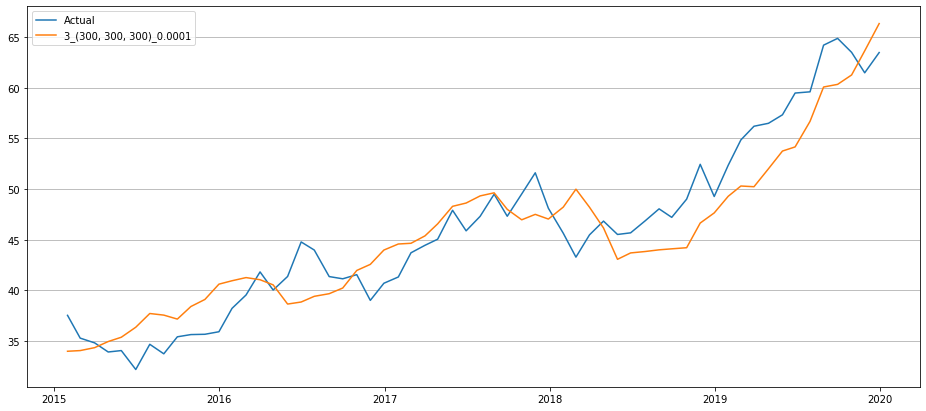

In [77]:
plt.figure(figsize = (16, 7))
plt.plot(test.iloc[:, 11], label = 'Actual')
for combo in mse_df.index[:1]:
    plt.plot(test.index, grid_results_dict[combo][2][:, 11], label = combo)
    
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()

In [78]:
predicted = grid_results_dict[mse_df.index[0]][2][:, 11]
actual = test.iloc[:, 11]

print('The R2 score is:\t{:0.3f}'.format(r2_score(actual, predicted)))

The R2 score is:	0.860


In [79]:
mse_df.index[0]

'3_(300, 300, 300)_0.0001'

In [81]:
import_model_wo_reg = False

if import_model_wo_reg:
    model = load_model('model/ae_model_wo_reg_2020_08_21.h5') # change date as required

else: 
    
    generator, model, true_predictions = hyper_search(
        n_input = 3, 
        n_nodes_list = (300, 300, 300), 
        lr = 0.0001,
        rate_dropout = 0.0, 
        act_funct = 'relu',  
        batch_size = 1,
        epochs = 100,
        patience = 3, 
        early_stop_bool = True
    )

Epoch 1/100
57/57 [==============================] - 2s 36ms/step - loss: 0.3210 - val_loss: 1.6086
Epoch 2/100
57/57 [==============================] - 1s 14ms/step - loss: 0.1579 - val_loss: 0.7448
Epoch 3/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0725 - val_loss: 1.3102
Epoch 4/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0692 - val_loss: 1.0817
Epoch 5/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0683 - val_loss: 1.2891
Epoch 6/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0671 - val_loss: 1.2901
Epoch 7/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0654 - val_loss: 1.2762
Epoch 8/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0621 - val_loss: 1.4712
Epoch 9/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0585 - val_loss: 1.3881
Epoch 10/100
57/57 [==============================] - 1s 14ms/step - loss: 0.0543 - val_loss: 1.8282

In [82]:
export_model_wo_reg = True

if export_model_wo_reg:
    model.save(f'model/lstm_model_wo_reg_{today}.h5')

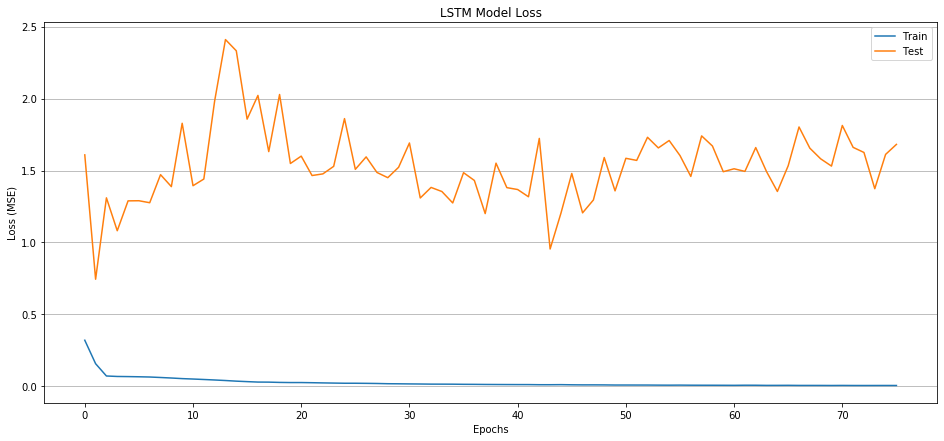

In [83]:
plt.figure(figsize = (16,7))
plt.plot(pd.Series(model.history.history['loss']), label = 'Train')
plt.plot(pd.Series(model.history.history['val_loss']), label = 'Test')
plt.legend()
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.grid(axis = 'y')
plt.show()

This model looks awful, but some regularisation could potentially improve it further. Using a dropout rate will be tested with the LSTM model

## Retrain the model with Regularisation this time

One approach is to use different dropout rates to see if that reduces the variance

In [84]:
do_rates = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35]

In [85]:
lstm_dropout_search_dict = {}

for rate in do_rates:

    lstm_dropout_search_dict[rate] = hyper_search(
        n_input = 12, 
        n_nodes_list = (500,), 
        lr = 1e-05,
        rate_dropout = rate, 
        act_funct = 'relu',  
        batch_size = 1,
        epochs = 100,
        patience = 3, 
        early_stop_bool = True
    )

Epoch 1/100
48/48 [==============================] - 1s 26ms/step - loss: 0.3342 - val_loss: 1.6127
Epoch 2/100
48/48 [==============================] - 1s 19ms/step - loss: 0.3021 - val_loss: 1.4663
Epoch 3/100
48/48 [==============================] - 1s 18ms/step - loss: 0.2679 - val_loss: 1.3113
Epoch 4/100
48/48 [==============================] - 1s 19ms/step - loss: 0.2303 - val_loss: 1.1152
Epoch 5/100
48/48 [==============================] - 1s 16ms/step - loss: 0.1855 - val_loss: 0.8900
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 0.1353 - val_loss: 0.6118
Epoch 7/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0886 - val_loss: 0.5130
Epoch 8/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0689 - val_loss: 0.5473
Epoch 9/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0639 - val_loss: 0.5429
Epoch 10/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0618 - val_loss: 0.5423

48/48 [==============================] - 1s 16ms/step - loss: 0.0232 - val_loss: 1.3643
Epoch 83/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0233 - val_loss: 1.3920
Epoch 84/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0224 - val_loss: 1.2185
Epoch 85/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0232 - val_loss: 1.3991
Epoch 86/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0224 - val_loss: 1.2695
Epoch 87/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0220 - val_loss: 1.4607
Epoch 88/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0227 - val_loss: 1.3252
Epoch 89/100
48/48 [==============================] - 1s 16ms/step - loss: 0.0224 - val_loss: 1.2772
Epoch 90/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0216 - val_loss: 1.3289
Epoch 91/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0217 - val_loss: 1.3409
Epo

48/48 [==============================] - 1s 15ms/step - loss: 0.0548 - val_loss: 0.6483
Epoch 21/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0558 - val_loss: 0.6469
Epoch 22/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0550 - val_loss: 0.6413
Epoch 23/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0536 - val_loss: 0.6275
Epoch 24/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0565 - val_loss: 0.6372
Epoch 25/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0546 - val_loss: 0.6121
Epoch 26/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0518 - val_loss: 0.6652
Epoch 27/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0519 - val_loss: 0.6573
Epoch 28/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0518 - val_loss: 0.6415
Epoch 29/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0511 - val_loss: 0.6463
Epo

48/48 [==============================] - 1s 14ms/step - loss: 0.0694 - val_loss: 0.5359
Epoch 12/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0675 - val_loss: 0.6045
Epoch 13/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0689 - val_loss: 0.5578
Epoch 14/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0662 - val_loss: 0.5769
Epoch 15/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0668 - val_loss: 0.5526
Epoch 16/100
48/48 [==============================] - 1s 14ms/step - loss: 0.0628 - val_loss: 0.5650
Epoch 17/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0651 - val_loss: 0.5617
Epoch 18/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0653 - val_loss: 0.5707
Epoch 19/100
48/48 [==============================] - 1s 15ms/step - loss: 0.0663 - val_loss: 0.5552
Epoch 1/100
48/48 [==============================] - 1s 23ms/step - loss: 0.3698 - val_loss: 1.8206
Epoc

In [86]:
lstm_dropout_search_dict

{0.01: (<keras.preprocessing.sequence.TimeseriesGenerator at 0x7fef98a37890>,
  array([[ 2.05312113e+01,  2.81833467e+00,  2.73002962e+00,
           2.83679291e+00,  2.92504904e+00,  8.11511205e-01,
           7.92651314e-01,  3.59468317e-01,  6.83287604e-01,
           9.74993617e-01,  7.76745561e-01,  3.35627787e+01,
           6.13029170e-03,  6.37715962e-02],
         [ 2.03377245e+01,  2.84487369e+00,  2.75100543e+00,
           2.85986832e+00,  2.95353250e+00,  7.09298885e-01,
           7.02108452e-01,  3.50345673e-01,  8.33144973e-01,
           9.97164663e-01,  6.55641230e-01,  3.42412558e+01,
           6.44020891e-03,  7.27350931e-02],
         [ 1.99892179e+01,  2.86673301e+00,  2.75986061e+00,
           2.87433532e+00,  2.97971471e+00,  5.89727658e-01,
           5.66775854e-01,  4.34012889e-01,  1.00999467e+00,
           9.12164898e-01,  4.90370010e-01,  3.51070748e+01,
           8.36680820e-03,  7.89088505e-02],
         [ 1.97219294e+01,  2.87929003e+00,  2.76005126

In [87]:
bias_variance_df = pd.DataFrame()

for k, v in lstm_dropout_search_dict.items(): 

    bias_variance_df.loc[k, 'train_error'] = v[1].history.history['loss'][-1]
    bias_variance_df.loc[k, 'test_error'] = v[1].history.history['val_loss'][-1]
    bias_variance_df.loc[k, 'difference'] = (
        np.abs(v[1].history.history['loss'][-1] - v[1].history.history['val_loss'][-1])
    )
    
    # adds the model without any regularisation
    bias_variance_df.loc['None', :] = [
        model.history.history['loss'][-1],
        model.history.history['val_loss'][-1],
        model.history.history['val_loss'][-1] - model.history.history['loss'][-1]
    ]

In [88]:
bias_variance_df.index = bias_variance_df.index.map(str)
bias_variance_df = bias_variance_df.sort_values('test_error')

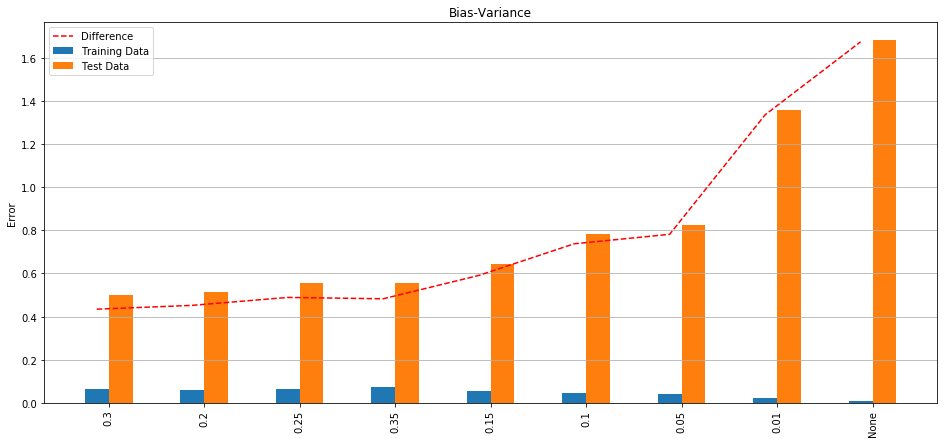

In [89]:
ind = np.arange(bias_variance_df.shape[0])
width = 0.25       

plt.figure(figsize = (16, 7))
plt.bar(ind, bias_variance_df['train_error'], width, label = 'Training Data')
plt.bar(ind + width, bias_variance_df['test_error'], width, label = 'Test Data')
# plt.bar(ind + width * 2, bias_variance_df['difference'], width, label = 'Difference')
plt.plot(bias_variance_df['difference'], label = 'Difference', color = 'r', linestyle = '--')

plt.ylabel('Error')
plt.title('Bias-Variance')

plt.xticks(ind + width / 2, bias_variance_df.index, rotation = 90)
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show() 

Based on the above chart, a dropout rate of 25% produces the lowest test error. At this rate, the training error is marginally worse than having no dropout rate. However, it looks like the improvement in the test error outweighs the slight deterioration in training error. It can therefore be said that adding a dropout helps improve the model generalisation. 

In [90]:
best_do_rate = bias_variance_df.sort_values('test_error').index[0]
model_low_test_reg = lstm_dropout_search_dict[float(best_do_rate)][1]
model_low_test_reg.save(f'model/lstm_model_w_low_test_reg_{today}.h5')

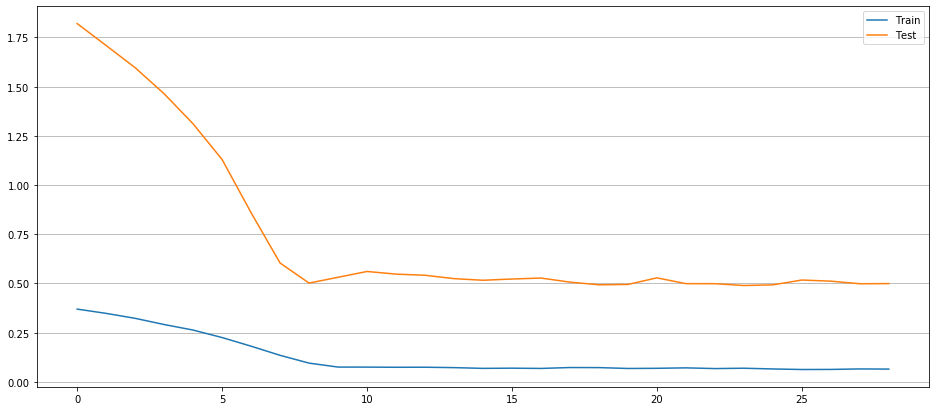

In [91]:
plt.figure(figsize = (16,7))
plt.plot(pd.Series(model_low_test_reg.history.history['loss']), label = 'Train')
plt.plot(pd.Series(model_low_test_reg.history.history['val_loss']), label = 'Test')
plt.legend()
plt.grid(axis = 'y')
plt.show()

In [92]:
model_low_test_reg_results = lstm_dropout_search_dict[float(best_do_rate)][2]

In [93]:
rolling_test = test.iloc[:, 11].rolling(3).mean()

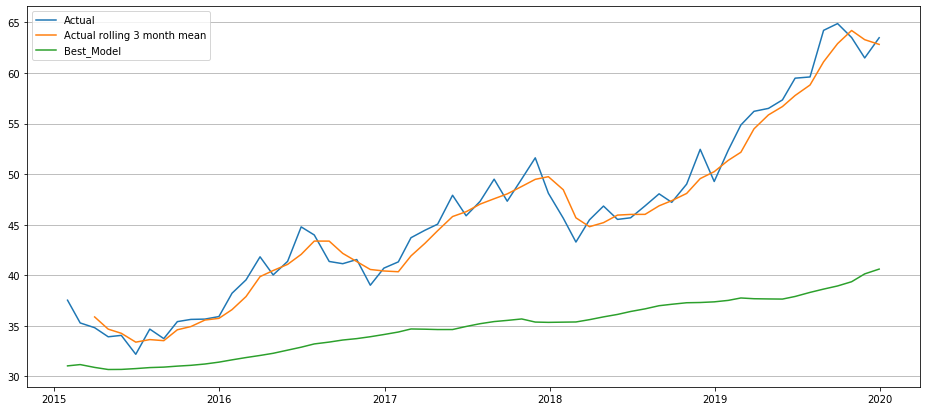

In [94]:
plt.figure(figsize = (16, 7))
plt.plot(test.iloc[:, 11], label = 'Actual')
plt.plot(rolling_test, label = 'Actual rolling 3 month mean')
plt.plot(test.index, model_low_test_reg_results[:, 11], label = 'Best_Model')
    
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show()